# <font color='green'>Projet 3 : Anticipez les besoins en consommation de bâtiments</font>

# Partie 1 : Nettoyage et exploration

## Sommaire

1. Objectifs
2. Données
 - Source des données
 - Description
3. Nettoyage
4. Analyse exploratoire
5. Feature engineering
6. Exportation des données pour la modèlisation

## 1. Objectifs

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation. Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

## 2. Données

In [257]:
# importation des librairies

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm

### Source des données :

https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

In [258]:
# chargement des fichiers

df = pd.read_csv('C:\\Users\\mfila\\2016_Building_Energy_Benchmarking.csv')

### Description

In [259]:
# taille du dataset

df.shape

(3376, 46)

In [260]:
# 5 premières lignes

df.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

In [261]:
# Variables disponibles et leur remplissage

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

Le dataset contient 3376 bâtiments decrits par 45 variables.

## 3. Nettoyage

### Premier choix des variables pertinentes 

Le but de l'étude est de prédire la consommation et les émissions des bâtiments non destinés à l’habitation. Nous allons d'abord analyser la variable **BuildingType** qui contient les informations sur les types d'utilisation des bâtiments.

In [262]:
# modalités de la colonne 'BuildingType'

df.BuildingType.unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Note: SPS-District K-12 correspod à Seattle Public Schools K–12, donc bâtiments non destinés à l’habitation.

Nous allons supprimer les lignes avec les bâtiments destinés à l'habitation.

In [263]:
# Supprimer les lignes 'Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)'

data = df.copy()
data = data[~data['BuildingType'].str.contains("Multifamily")]
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

Vérifions la présence des doublons par ID de bâtiment. 

In [264]:
# Recherche des doublons par ID de bâtiment

data[data.OSEBuildingID.duplicated()]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

[0 rows x 46 columns]

In [265]:
# taille de dataset des bâtiments non destinés à l’habitation

data.shape

(1668, 46)

Après la suppression des bâtiments destinés à l'habitation et la recherche des doublons le dataset contient 1668 lignes. Nous allons ensuite analyser le remplissage des variables.

<AxesSubplot:>

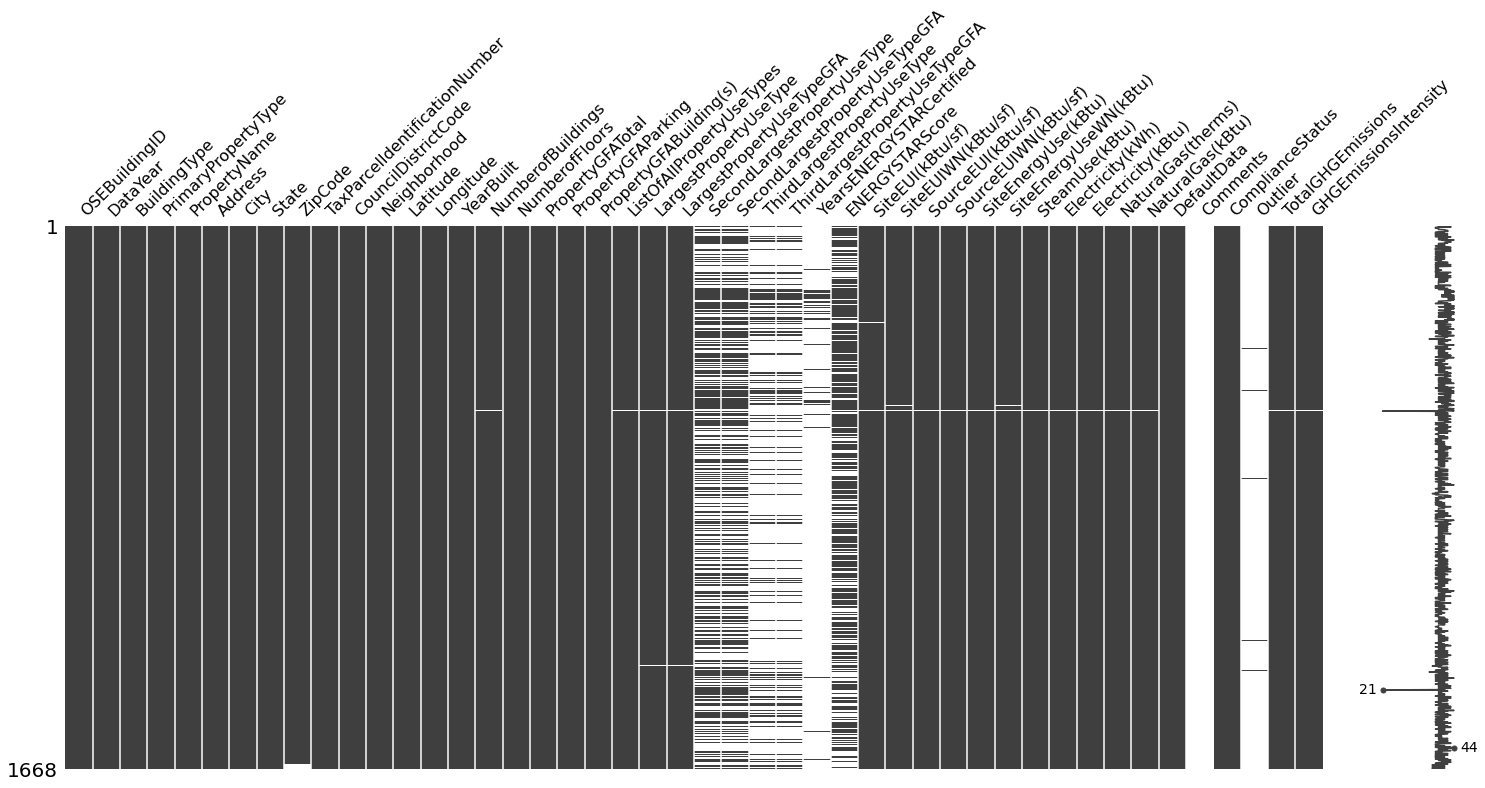

In [266]:
# visualiser le remplissage des variables

msno.matrix(data)

In [267]:
# Fonction pour calculer le nombre et le pourcentage des données manquantes dans chaque colonne

def taux_remplissage(df):
    valeurs_manquantes=df.isnull().sum().sort_values()
    pourcentage=100 * valeurs_manquantes / len(df)
    df_null = pd.concat([valeurs_manquantes, pourcentage.round(2)], axis=1)
    df_null.columns = ['Nombre_valeurs_manquantes', 'Pourcentage_valeurs_manquantes']
    return(df_null)

In [268]:
# nombre et pourcentage des données manquantes dans chaque colonne

taux_remplissage(data)

Nombre_valeurs_manquantes  \
OSEBuildingID                                            0   
PropertyGFABuilding(s)                                   0   
PropertyGFAParking                                       0   
PropertyGFATotal                                         0   
NumberofFloors                                           0   
DefaultData                                              0   
YearBuilt                                                0   
Latitude                                                 0   
Neighborhood                                             0   
CouncilDistrictCode                                      0   
Longitude                                                0   
ComplianceStatus                                         0   
TaxParcelIdentificationNumber                            0   
BuildingType                                             0   
PrimaryPropertyType                                      0   
PropertyName                                             0   
DataYear                                                 0   
City                                                     0   
State                                                    0   
Address                                                  0   
SourceEUIWN(kBtu/sf)                                     2   
NaturalGas(kBtu)                                         2   
NaturalGas(therms)                                       2   
Electricity(kBtu)                                        2   
Electricity(kWh)                                         2   
SteamUse(kBtu)                                           2   
SiteEnergyUse(kBtu)                                      2   
SourceEUI(kBtu/sf)                                       2   
GHGEmissionsIntensity                                    2   
TotalGHGEmissions                                        2   
NumberofBuildings                                        2   
ListOfAllPropertyUseTypes                                2   
SiteEnergyUseWN(kBtu)                                    3   
SiteEUI(kBtu/sf)                                         3   
SiteEUIWN(kBtu/sf)                                       3   
LargestPropertyUseType                                   6   
LargestPropertyUseTypeGFA                                6   
ZipCode                                                 16   
ENERGYSTARScore                                        574   
SecondLargestPropertyUseTypeGFA                        813   
SecondLargestPropertyUseType                           813   
ThirdLargestPropertyUseTypeGFA                        1315   
ThirdLargestPropertyUseType                           1315   
YearsENERGYSTARCertified                              1570   
Outlier                                               1651   
Comments                                              1668   

                                 Pourcentage_valeurs_manquantes  
OSEBuildingID                                              0.00  
PropertyGFABuilding(s)                                     0.00  
PropertyGFAParking                                         0.00  
PropertyGFATotal                                           0.00  
NumberofFloors                                             0.00  
DefaultData                                                0.00  
YearBuilt                                                  0.00  
Latitude                                                   0.00  
Neighborhood                                               0.00  
CouncilDistrictCode                                        0.00  
Longitude                                                  0.00  
ComplianceStatus                                           0.00  
TaxParcelIdentificationNumber                              0.00  
BuildingType                                               0.00  
PrimaryPropertyType                                        0.00  
PropertyName                                               0.0

Plusieures variables sont mal remplies. Nous allons faire un premier tri des variables potentiellement pertinentes pour le futur modélisation.

In [269]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

D'abord, vérifions les variables qui semblent avoir q'une seule modalité, donc serait inutiles pour notre étude. 

In [270]:
# modalités de la variable 'City'

data.City.unique()

array(['Seattle'], dtype=object)

In [271]:
# modalités de la variable 'State'

data.State.unique()

array(['WA'], dtype=object)

In [272]:
# modalités de la variable 'DataYear'

data.DataYear.unique()

array([2016], dtype=int64)

Supprimons les variables qui contiennent d'une seule modalité.

In [273]:
# Suppression des 3 variables qui contiennent q'une seule modalité

data.drop(['City','State','DataYear'], axis=1, inplace=True)

In [274]:
# variables restantes

data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Address', 'ZipCode', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmissions', 'GHGE

Parmi les variables restantes nous distinguons les variables liées à :

- identification du bâtiment (ID, adresse)
- sa situation géographique (zip code, latitude, longitude,neighborhood, Council district code)
- ancienneté (année de construction)
- type d'utilisation
- informations techniques des bâtiments (nombre de bâtiments et étages, surface)
- consommation énergétique de bâtiment 
- information sur les émissions de gaz à effet de serre
- ENERGYSTARScore : variable importante, l’intérêt à évaluer pour la prédiction des émissions 

Certaines variables sont redondantes, nottament celles qui decrivent la consommation énergetique et les émissions que nous cherchons à prédire.

Pour la prédiction de la consommation énergetique nous allons choisir la variable cible **SiteEnergyUseWN(kBtu)** qui respresente la quantité annuelle d’énergie consommée par la propriété à partir de toutes les sources d’énergie normalisée par la météo (ajustée à ce que la propriété aurait consommé pendant les conditions météorologiques moyennes sur 30 ans). Les variables de la consommation brute et de la consommation ramenée à l'unité de surface de bâtiment sont redondantes, nous allons les supprimer.

Variable cible pour la prédiction des émissions retenue est **TotalGHGEmissions**. Elle represente la quantité totale d’émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et l’oxyde nitreux rejetés dans l’atmosphère en raison de la consommation d’énergie par la propriété, mesurée en tonnes métriques d’équivalent dioxyde de carbone. La variable redondante 'GHGEmissionsIntensity' est à supprimer.

Nous allons laisser 3 variables qui permettrait d'étudier le pourcentage de types d'énergie utilisés exprimées dans les mêmes entités 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'. Les variables redondantes à supprimer : 
'Electricity(kWh)','NaturalGas(therms)'.

In [276]:
# Suppression des variables de la consommation et des émissions redondantes

data.drop(['SiteEnergyUse(kBtu)','GHGEmissionsIntensity','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 
           'SourceEUIWN(kBtu/sf)','Electricity(kWh)','NaturalGas(therms)'], axis=1, inplace=True)

Nous allons ensuite supprimer les variables non pertinentes :

- 'DefaultData' : Les données par défaut ont été utilisées pour au moins une caractéristique de propriété
- 'ComplianceStatus' : Si une propriété a satisfait aux exigences d’analyse comparative énergétique pour l’année de déclaration en cours.
- 'TaxParcelIdentificationNumber','Address','PropertyName' : identification de bâtiment redondante
- 'YearsENERGYSTARCertified' : années d'obtention de la certification ENERGY STAR

In [277]:
# Suppression des variables non utiles

data.drop(['DefaultData','ComplianceStatus','TaxParcelIdentificationNumber','Address','PropertyName',
           'YearsENERGYSTARCertified'], axis=1, inplace=True)

Parmi des varaibles restantes, 10 représentent les surfaces et les types d'utilisation de bâtiment :

- surface ('PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)')
- type d'utilisation ('ListOfAllPropertyUseTypes', 
  'LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType')
- surface en fonction de type d'utilisation ('LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',  
  'ThirdLargestPropertyUseTypeGFA')

In [280]:
# modalités de la variable 'liste de types d'utilisation de bâtiments'

data.ListOfAllPropertyUseTypes.unique()

array(['Hotel', 'Hotel, Parking, Restaurant',
       'Hotel, Parking, Swimming Pool', 'Police Station',
       'Other - Entertainment/Public Assembly', 'Hotel, Parking',
       'Data Center, Library, Parking',
       'Fitness Center/Health Club/Gym, Office, Swimming Pool',
       'Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership',
       'Hotel, Parking, Retail Store, Swimming Pool',
       'K-12 School, Multifamily Housing, Office, Other - Entertainment/Public Assembly',
       'Self-Storage Facility',
       'Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office',
       'Non-Refrigerated Warehouse, Office, Refrigerated Warehouse',
       'Non-Refrigerated Warehouse, Office', 'Office, Other - Education',
       'Office, Self-Storage Facility, Vocational School',
       'Data Center, Office, Retail Store',
       '

La variable 'ListOfAllPropertyUseTypes' contient un très grand nombre de modalités, partiellement redondantes par rapport 
aux autres variables, nous allons la supprimer. 

In [281]:
# Suppression de la variable non utile

data.drop(['ListOfAllPropertyUseTypes'], axis=1, inplace=True)

In [279]:
# variables restantes

data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'Comments', 'Outlier', 'TotalGHGEmissions'],
      dtype='object')

### Traitement des valeurs manquantes et aberrantes

**Traitement des valeurs absentes**

<AxesSubplot:>

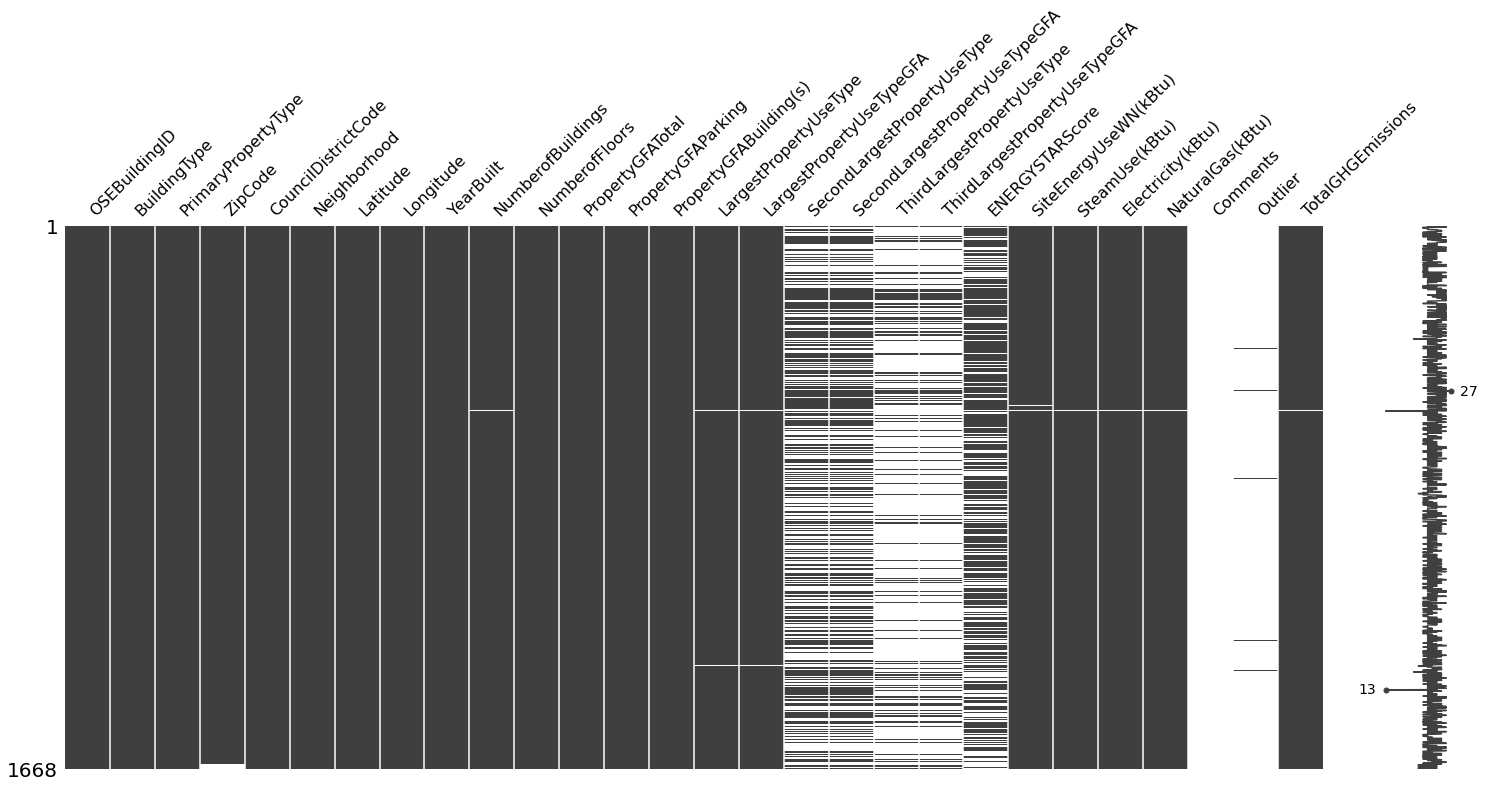

In [282]:
# visualiser le remplissage du dataframe après la première étape de suppression des variables inutiles

msno.matrix(data)

In [283]:
taux_remplissage(data)

Nombre_valeurs_manquantes  \
OSEBuildingID                                            0   
PropertyGFAParking                                       0   
PropertyGFATotal                                         0   
NumberofFloors                                           0   
YearBuilt                                                0   
Longitude                                                0   
PropertyGFABuilding(s)                                   0   
Neighborhood                                             0   
CouncilDistrictCode                                      0   
PrimaryPropertyType                                      0   
BuildingType                                             0   
Latitude                                                 0   
NaturalGas(kBtu)                                         2   
Electricity(kBtu)                                        2   
SteamUse(kBtu)                                           2   
TotalGHGEmissions                                        2   
NumberofBuildings                                        2   
SiteEnergyUseWN(kBtu)                                    3   
LargestPropertyUseType                                   6   
LargestPropertyUseTypeGFA                                6   
ZipCode                                                 16   
ENERGYSTARScore                                        574   
SecondLargestPropertyUseType                           813   
SecondLargestPropertyUseTypeGFA                        813   
ThirdLargestPropertyUseType                           1315   
ThirdLargestPropertyUseTypeGFA                        1315   
Outlier                                               1651   
Comments                                              1668   

                                 Pourcentage_valeurs_manquantes  
OSEBuildingID                                              0.00  
PropertyGFAParking                                         0.00  
PropertyGFATotal                                           0.00  
NumberofFloors                                             0.00  
YearBuilt                                                  0.00  
Longitude                                                  0.00  
PropertyGFABuilding(s)                                     0.00  
Neighborhood                                               0.00  
CouncilDistrictCode                                        0.00  
PrimaryPropertyType                                        0.00  
BuildingType                                               0.00  
Latitude                                                   0.00  
NaturalGas(kBtu)                                           0.12  
Electricity(kBtu)                                          0.12  
SteamUse(kBtu)                                             0.12  
TotalGHGEmissions                                          0.12  
NumberofBuildings                                          0.12  
SiteEnergyUseWN(kBtu)                                      0.18  
LargestPropertyUseType                                     0.36  
LargestPropertyUseTypeGFA                                  0.36  
ZipCode                                                    0.96  
ENERGYSTARScore                                           34.41  
SecondLargestPropertyUseType                              48.74  
SecondLargestPropertyUseTypeGFA                           48.74  
ThirdLargestPropertyUseType                               78.84  
ThirdLargestPropertyUseTypeGFA                            78.84  
Outlier                                                   98.98  
Comments                                                 100.00

In [284]:
# Verification des variables mal remplies (Outlier)

data.Outlier.value_counts()

Low outlier     15
High outlier     2
Name: Outlier, dtype: int64

La colonne 'Outlier' est presque vide, mais mes informations présentes peuvent être utiles, nous allons la conserver et remplacer les Nan par 'Not'

In [285]:
# Remplace Nan pour la colonne 'Outlier' par 'Not'

data['Outlier'] = data['Outlier'].fillna('Not')

La variable 'Comments' est vide à 100 %, nous allons la supprimer.

In [286]:
# Supprimer la variable 'Comments' vide à 100 %

data.drop(['Comments'], axis=1, inplace=True)

Nous considerons que les valeurs absentes des colonnes liées aux 2 et 3 types d'utilisation du batiment peuvent être remplacées par 0 pour les variables numériques et par 'Not known' pour les variables catégorielles car correspondent à l'absence de 2ème ou 3ème type l'utilisation.

In [287]:
# Remplacement des valeurs absentes des colonnes liées aux 2 et 3 types d'utilisation 
# du batiment par 0 pour les variables numériques et par 'Not known' 
# pour les variables catégorielles

list_col = ['ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA']
data[list_col] = data[list_col].fillna(0)

list_col2 = ['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
data[list_col2] = data[list_col2].fillna('Not known')

Variable ENERGYSTARScore a beaucoup de valeurs absentes, mais est importante pour la prédiction d’émissions, nous allons la laisser. Les autres variables contiennent un très petit taux des valeurs absentes, nous allons supprimer les lignes correspondantes. 

In [288]:
# Supprimer les lignes Nan pour toutes les colonnes sauf ENERGYSTARScore

index_nan = data[data.loc[:, data.columns != 'ENERGYSTARScore'].isna().sum(axis=1) > 0].index
data.drop(index=index_nan, inplace=True)

<AxesSubplot:>

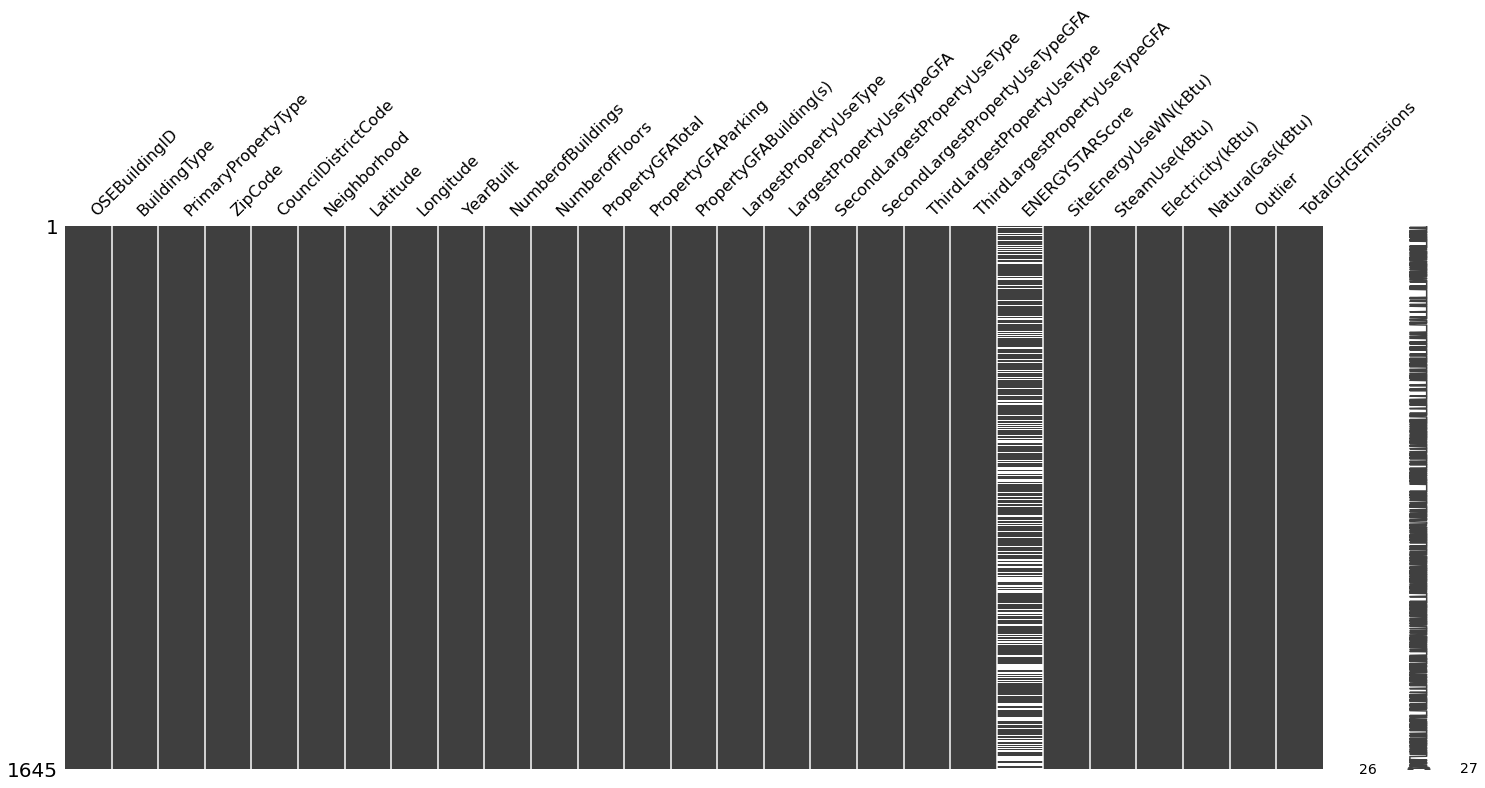

In [289]:
# verification du remplissage après les traitements

msno.matrix(data)

In [290]:
# type des variables de dataframe

data.columns.to_series().groupby(data.dtypes).groups    

{int64: ['OSEBuildingID', 'CouncilDistrictCode', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)'], float64: ['ZipCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions'], object: ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'Outlier']}

**Recherche des valeurs aberrantes : varaibles numériques**

Vérification des adresses sur la carte de ville de Seattle.

In [292]:
import folium
map_osm = folium.Map()
map_osm = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()],zoom_start=11)
for i in range(0, len(data)):
    folium.Circle([data.iloc[i]['Latitude'], data.iloc[i]['Longitude']], 
                      popup=df.iloc[i]['Address'], radius=50).add_to(map_osm)
map_osm

Vérification des zip codes.

In [293]:
# modalités de la variable zipcode

data.ZipCode.unique()

array([98101., 98121., 98104., 98154., 98118., 98105., 98112., 98125.,
       98109., 98070., 98108., 98199., 98115., 98107., 98144., 98103.,
       98119., 98136., 98122., 98126., 98133., 98146., 98033., 98106.,
       98111., 98134., 98117., 98116., 98191., 98164., 98195., 98185.,
       98181., 98102., 98168., 98155., 98006., 98124., 98053., 98013.,
       98178., 98114., 98165., 98011., 98113., 98177., 98020., 98145.])

Les adresses et les zip codes correspondent à la ville de Seattle.

Vérification de la variable CountryDistrictCode.

In [294]:
# modalités de la variable CouncilDistrctCode

data.CouncilDistrictCode.unique()

array([7, 3, 2, 4, 5, 6, 1], dtype=int64)

Vérification des max et min pour les variables numériques.

In [295]:
data.describe()

OSEBuildingID       ZipCode  CouncilDistrictCode     Latitude  \
count    1645.000000   1645.000000          1645.000000  1645.000000   
mean    16014.996960  98116.851672             4.358055    47.615963   
std     13497.797615     18.456495             2.192126     0.048098   
min         1.000000  98006.000000             1.000000    47.499170   
25%       578.000000  98105.000000             2.000000    47.585420   
50%     21122.000000  98109.000000             4.000000    47.612340   
75%     24560.000000  98125.000000             7.000000    47.649630   
max     50101.000000  98199.000000             7.000000    47.733870   

         Longitude    YearBuilt  NumberofBuildings  NumberofFloors  \
count  1645.000000  1645.000000        1645.000000     1645.000000   
mean   -122.332874  1961.889970           1.170213        4.150760   
std       0.024446    32.710474           2.949941        6.600367   
min    -122.411820  1900.000000           0.000000        0.000000   
25%    -122.343180  1930.000000           1.000000        1.000000   
50%    -122.332970  1965.000000           1.000000        2.000000   
75%    -122.321750  1989.000000           1.000000        4.000000   
max    -122.258640  2015.000000         111.000000       99.000000   

       PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count      1.645000e+03         1645.000000            1.645000e+03   
mean       1.200696e+05        13025.330699            1.070443e+05   
std        2.992294e+05        42503.409562            2.860259e+05   
min        1.630000e+04            0.000000            3.636000e+03   
25%        3.000000e+04            0.000000            2.880000e+04   
50%        5.000000e+04            0.000000            4.786300e+04   
75%        1.075720e+05            0.000000            9.599500e+04   
max        9.320156e+06       512608.000000            9.320156e+06   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count               1.645000e+03                      1645.000000   
mean                9.959429e+04                     19095.223281   
std                 2.780047e+05                     53604.868023   
min                 5.656000e+03                         0.000000   
25%                 2.582100e+04                         0.000000   
50%                 4.434000e+04                         0.000000   
75%                 9.230000e+04                     12890.000000   
max                 9.320156e+06                    686750.000000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUseWN(kBtu)  \
count                     1645.000000      1088.000000           1.645000e+03   
mean                      3197.818479        65.401654           8.136321e+06   
std                      18093.788343        28.520421           2.216163e+07   
min                          0.000000         1.000000           0.000000e+00   
25%                          0.000000        48.000000           1.315191e+06   
50%                          0.000000        73.000000           2.709055e+06   
75%                          0.000000        89.000000           7.251589e+06   
max                     459748.000000       100.000000           4.716139e+08   

       SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
count    1.645000e+03       1.645000e+03      1.645000e+03        1645.000000  
mean     5.191160e+05       5.903204e+06      1.982337e+06         186.505003  
std      5.548742e+06       2.092193e+07      9.428572e+06         756.589527  
min      0.000000e+00      -1.154170e+05      0.000000e+00          -0.800000  
25%      0.000000e+00       7.273860e+05      0.000000e+00          19.890000  
50%      0.000000e+00       1.632472e+06      5.038750e+05          49.790000  
75%      0.000000e+00       4.904243e+06      1.522809e+06         143.340000  
max      1.349435e+08       6.570744e+08      2.979090e+08       16870.980000

Vérification de la variable 'YearBuilt' : Année de contruction entre 1900 et 2015, pas d'anomalie idéntifiée. 

Vérification de la variable NumberOfBuildings.

In [296]:
# modalités de la varaible 'NumberofBuildings'

data['NumberofBuildings'].unique()

array([  1.,   3.,   0.,   2.,   4.,  27.,   6.,  11.,  14.,   9.,   5.,
         7.,   8.,  23.,  10., 111.])

In [297]:
# zoom sur la ligne avec un très nombre de bâtiments

data[data['NumberofBuildings'] == 111]

OSEBuildingID BuildingType PrimaryPropertyType  ZipCode  \
3274          49967       Campus          University  98105.0   

      CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
3274                    4    NORTHEAST  47.65644 -122.31041       1900   

      NumberofBuildings  ...  SecondLargestPropertyUseTypeGFA  \
3274              111.0  ...                              0.0   

      ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
3274                    Not known                             0.0   

      ENERGYSTARScore SiteEnergyUseWN(kBtu)  SteamUse(kBtu) Electricity(kBtu)  \
3274              NaN                   0.0      84985240.0       657074389.0   

      NaturalGas(kBtu) Outlier  TotalGHGEmissions  
3274               0.0     Not           11140.56  

[1 rows x 27 columns]

La construction est un campus uiversitaire, nous considerons que 111 bâtiments n'est pas une valeur aberrante mais atypique.

In [298]:
# zoom sur les lignes avec le nombre de bâtiments = 0

data[data['NumberofBuildings'] == 0]

OSEBuildingID        BuildingType          PrimaryPropertyType  ZipCode  \
63               89      NonResidential               Medical Office  98122.0   
76              113      NonResidential  Small- and Mid-Sized Office  98109.0   
160             257      NonResidential                    Warehouse  98134.0   
201             322      NonResidential                 Large Office  98121.0   
241             366      NonResidential  Small- and Mid-Sized Office  98105.0   
264             391      NonResidential           Mixed Use Property  98108.0   
278             408      NonResidential                 Large Office  98101.0   
280             410      NonResidential                        Hotel  98101.0   
291             421      NonResidential                        Other  98101.0   
358             504  Nonresidential COS                        Other  98118.0   
365             517      NonResidential  Supermarket / Grocery Store  98133.0   
417             576      NonResidential                        Other  98125.0   
429             588      NonResidential           Mixed Use Property  98102.0   
433             594      NonResidential                        Other  98134.0   
477             640      NonResidential                 Large Office  98134.0   
481             649      NonResidential  Small- and Mid-Sized Office  98134.0   
488             657      NonResidential           Mixed Use Property  98121.0   
494             673      NonResidential                 Retail Store  98106.0   
544             735      NonResidential                    Warehouse  98199.0   
608             812      NonResidential                    Warehouse  98134.0   
809           19900      NonResidential                   Laboratory  98121.0   
952           20323      NonResidential               Residence Hall  98104.0   
985           20427      NonResidential           Mixed Use Property  98116.0   
1002          20474      NonResidential                        Other  98125.0   
1025          20532  Nonresidential COS                        Other  98134.0   
1177          21180      NonResidential                        Other  98103.0   
1244          21336      NonResidential                        Other  98104.0   
1256          21365      NonResidential               Medical Office  98114.0   
1317          21508      NonResidential                        Other  98121.0   
1606          22801  Nonresidential COS                        Other  98125.0   
2054          24270      NonResidential             Worship Facility  98103.0   
2115          24514      NonResidential  Supermarket / Grocery Store  98133.0   
2166          24646  Nonresidential COS                        Other  98106.0   
2188          24716      NonResidential       Refrigerated Warehouse  98134.0   
2214          24822      NonResidential  Small- and Mid-Sized Office  98134.0   
2382          25461      NonResidential                   Restaurant  98109.0   
2407          25546      NonResidential           Mixed Use Property  98104.0   
2441          25661      NonResidential  Small- and Mid-Sized Office  98104.0   
2482          25772      NonResidential                     Hospital  98116.0   
2564          26119      NonResidential                 Retail Store  98122.0   
2631          26331      NonResidential  Small- and Mid-Sized Office  98103.0   
2708          26706      NonResidential  Small- and Mid-Sized Office  98104.0   
2715          26719      NonResidential  Small- and Mid-Sized Office  98104.0   
2747          26833      NonResidential  Small- and Mid-Sized Office  98104.0   
2782          26924  Nonresidential COS           Mixed Use Property  98122.0   
2963          27673      NonResidential                        Hotel  98104.0   
3108          33289      NonResidential                 Large Office  98121.0   
3121          36034      NonResidential                 Retail Store  98122.0   
3155          45287  Nonresidential C

Après la vérification, les adresses ont bien un bâtiment, nous allons remplacer les 0 par 1.

In [299]:
# remplacer les 0 par 1 dans la colonne 'NumberofBuildings'

data['NumberofBuildings'].replace(0, 1, inplace=True)

Vérification de la variable NumberofFloors.

In [300]:
# zoom sur la ligne avec le nombre d'étages = 99

data[data['NumberofFloors'] == 99]

OSEBuildingID    BuildingType PrimaryPropertyType  ZipCode  \
1359          21611  NonResidential    Worship Facility  98108.0   

      CouncilDistrictCode      Neighborhood  Latitude  Longitude  YearBuilt  \
1359                    2  GREATER DUWAMISH  47.55072 -122.30265       1977   

      NumberofBuildings  ...  SecondLargestPropertyUseTypeGFA  \
1359                1.0  ...                              0.0   

      ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
1359                    Not known                             0.0   

      ENERGYSTARScore SiteEnergyUseWN(kBtu)  SteamUse(kBtu) Electricity(kBtu)  \
1359             80.0           326001.1875             0.0          326001.0   

      NaturalGas(kBtu) Outlier  TotalGHGEmissions  
1359               0.0     Not               2.27  

[1 rows x 27 columns]

Après la vérification de l'adresse sur la carte Google maps (5801 Beacon Avenue South, Seattle), le bâtiment est une eglise avec 1 étage 5801, nous allons remplacer une valeur aberrante.	

In [301]:
# remplacer 99 par 1 dans la colonne 'NumberofFloors'

data['NumberofFloors'].replace(99, 1, inplace=True)

In [302]:
data.describe()

OSEBuildingID       ZipCode  CouncilDistrictCode     Latitude  \
count    1645.000000   1645.000000          1645.000000  1645.000000   
mean    16014.996960  98116.851672             4.358055    47.615963   
std     13497.797615     18.456495             2.192126     0.048098   
min         1.000000  98006.000000             1.000000    47.499170   
25%       578.000000  98105.000000             2.000000    47.585420   
50%     21122.000000  98109.000000             4.000000    47.612340   
75%     24560.000000  98125.000000             7.000000    47.649630   
max     50101.000000  98199.000000             7.000000    47.733870   

         Longitude    YearBuilt  NumberofBuildings  NumberofFloors  \
count  1645.000000  1645.000000        1645.000000     1645.000000   
mean   -122.332874  1961.889970           1.201824        4.091185   
std       0.024446    32.710474           2.942576        6.172122   
min    -122.411820  1900.000000           1.000000        0.000000   
25%    -122.343180  1930.000000           1.000000        1.000000   
50%    -122.332970  1965.000000           1.000000        2.000000   
75%    -122.321750  1989.000000           1.000000        4.000000   
max    -122.258640  2015.000000         111.000000       76.000000   

       PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count      1.645000e+03         1645.000000            1.645000e+03   
mean       1.200696e+05        13025.330699            1.070443e+05   
std        2.992294e+05        42503.409562            2.860259e+05   
min        1.630000e+04            0.000000            3.636000e+03   
25%        3.000000e+04            0.000000            2.880000e+04   
50%        5.000000e+04            0.000000            4.786300e+04   
75%        1.075720e+05            0.000000            9.599500e+04   
max        9.320156e+06       512608.000000            9.320156e+06   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count               1.645000e+03                      1645.000000   
mean                9.959429e+04                     19095.223281   
std                 2.780047e+05                     53604.868023   
min                 5.656000e+03                         0.000000   
25%                 2.582100e+04                         0.000000   
50%                 4.434000e+04                         0.000000   
75%                 9.230000e+04                     12890.000000   
max                 9.320156e+06                    686750.000000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUseWN(kBtu)  \
count                     1645.000000      1088.000000           1.645000e+03   
mean                      3197.818479        65.401654           8.136321e+06   
std                      18093.788343        28.520421           2.216163e+07   
min                          0.000000         1.000000           0.000000e+00   
25%                          0.000000        48.000000           1.315191e+06   
50%                          0.000000        73.000000           2.709055e+06   
75%                          0.000000        89.000000           7.251589e+06   
max                     459748.000000       100.000000           4.716139e+08   

       SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  
count    1.645000e+03       1.645000e+03      1.645000e+03        1645.000000  
mean     5.191160e+05       5.903204e+06      1.982337e+06         186.505003  
std      5.548742e+06       2.092193e+07      9.428572e+06         756.589527  
min      0.000000e+00      -1.154170e+05      0.000000e+00          -0.800000  
25%      0.000000e+00       7.273860e+05      0.000000e+00          19.890000  
50%      0.000000e+00       1.632472e+06      5.038750e+05          49.790000  
75%      0.000000e+00       4.904243e+06      1.522809e+06         143.340000  
max      1.349435e+08       6.570744e+08      2.979090e+08       16870.980000

In [303]:
# zoom sur les lignes avec le nombre d'étages = 0

data[data['NumberofFloors'] == 0]

OSEBuildingID        BuildingType          PrimaryPropertyType  ZipCode  \
166             267      NonResidential                        Hotel  98101.0   
487             656      NonResidential               Medical Office  98104.0   
488             657      NonResidential           Mixed Use Property  98121.0   
564             758      NonResidential                        Other  98101.0   
1754          23311      NonResidential               Medical Office  98104.0   
1993          24086              Campus                        Other  98134.0   
3130          40028      NonResidential                    Warehouse  98115.0   
3131          40031      NonResidential               Medical Office  98115.0   
3132          40034      NonResidential  Small- and Mid-Sized Office  98115.0   
3168          49705  Nonresidential COS                        Other  98115.0   
3273          49966      NonResidential                        Other  98108.0   
3274          49967              Campus                   University  98105.0   
3276          49970      NonResidential               Residence Hall  98105.0   
3278          49979      NonResidential               Residence Hall  98195.0   
3279          49980      NonResidential               Residence Hall  98195.0   
3280          49983      NonResidential               Residence Hall  98195.0   

      CouncilDistrictCode      Neighborhood  Latitude  Longitude  YearBuilt  \
166                     7          DOWNTOWN  47.61275 -122.33330       1999   
487                     3              EAST  47.60979 -122.32298       2004   
488                     7          DOWNTOWN  47.61783 -122.33729       2006   
564                     7          DOWNTOWN  47.61289 -122.33531       1999   
1754                    3              EAST  47.60862 -122.32372       1945   
1993                    2  GREATER DUWAMISH  47.59042 -122.32498       1991   
3130                    4         NORTHEAST  47.68454 -122.26235       1940   
3131                    4         NORTHEAST  47.68240 -122.26223       1960   
3132                    4         NORTHEAST  47.68254 -122.26299       1960   
3168                    4         NORTHEAST  47.68212 -122.26330       1929   
3273                    2         SOUTHEAST  47.56260 -122.29396       2009   
3274                    4         NORTHEAST  47.65644 -122.31041       1900   
3276                    4         NORTHEAST  47.65718 -122.31632       2011   
3278                    4         NORTHEAST  47.65577 -122.31530       1953   
3279                    4         NORTHEAST  47.65447 -122.31733       1970   
3280                    4         NORTHEAST  47.65176 -122.30756       2011   

      NumberofBuildings  ...  SecondLargestPropertyUseTypeGFA  \
166                 1.0  ...                         438756.0   
487                 1.0  ...                              0.0   
488                 1.0  ...                         340236.0   
564                 1.0  ...                         100000.0   
1754                1.0  ...                         135954.0   
1993               10.0  ...                              0.0   
3130                1.0  ...                          63872.0   
3131                1.0  ...                              0.0   
3132                1.0  ...                          31845.0   
3168                8.0  ...                              0.0   
3273                1.0  ...                              0.0   
3274              111.0  ...                              0.0   
3276                1.0  ...                          24000.0   
3278                1.0  ...                              0.0   
3279                1.0  ...                              0.0   
3280                1.0  ...                              0.0   

      ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
166                    Restaurant                         49700.0   
487                     Not known       

Ces bâtiments ont au moins 1 étage, nous allons remplacer les 0 par 1.

In [304]:
# remplacer 0 par 1 dans la colonne 'NumberofFloors'

data['NumberofFloors'].replace(0, 1, inplace=True)

Pour les variables qui répresentent les surfaces et les emissions les valeurs doivent être positives, aussi que pour la consommation sauf si le bâtiment produit de l'électricité. Nous remarquons que les minimum des deux colonnes TotalGHGEmissions et Electricity(kBtu) sont négatives.

In [305]:
# zoom sur les lignes avec TotalGHGEmissions négatif

df[df['TotalGHGEmissions'] < 0]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
3206          49784      2016  NonResidential  Small- and Mid-Sized Office   

        PropertyName              Address     City State  ZipCode  \
3206  Bullitt Center  1501 E. Madison St.  Seattle    WA  98122.0   

     TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
3206                    7234600195  ...      -33826.80078         -115417.0   

      NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
3206                 0.0               0.0        False       NaN   

      ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
3206         Compliant      NaN               -0.8                  -0.02  

[1 rows x 46 columns]

La recherche des photos du bâtiment par l'adresse (1501 E. Madison St, Seattle) nous donne des informations complémentaires : il s'agit d'un bâtiment moderne avec des batteries solaires installées sur les toits, la consommation de l'électricité peut donc être négative, ce n'est pas une valeur erronée. Nous allons néanmoins supprimer la ligne correspondante car ce batiment est un outlier unique et peut donc impacter la performance des futures modèlisations. 

**Recherche des valeurs aberrantes : varaibles catégorielles**

Vérification de la variable 'BuildingType'

In [306]:
data.BuildingType.value_counts()

NonResidential        1453
SPS-District K-12       98
Nonresidential COS      69
Campus                  24
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [307]:
# Renommer 'Nonresidential COS' et 'Nonresidential WA' en 'NonResidential'

data['BuildingType'] = data['BuildingType'].str.replace(
    'Nonresidential COS', 'NonResidential')
data['BuildingType'] = data['BuildingType'].str.replace(
    'Nonresidential WA', 'NonResidential')

Vérification de la variable 'Neighborhood'

In [308]:
# modalités de la variable 'Neighborhood'

pd.DataFrame({'Neighborhood' :data['Neighborhood'].unique()}).sort_values(by='Neighborhood')

Neighborhood
9                 BALLARD
14                Ballard
11                CENTRAL
4                 Central
13               DELRIDGE
0                DOWNTOWN
16               Delridge
3                    EAST
8        GREATER DUWAMISH
7              LAKE UNION
6   MAGNOLIA / QUEEN ANNE
5                   NORTH
2               NORTHEAST
10              NORTHWEST
15                  North
17              Northwest
1               SOUTHEAST
12              SOUTHWEST

In [309]:
# Correction des modalités d'écriture

data['Neighborhood'] = data['Neighborhood'].apply(lambda x: x.upper().strip())
data['Neighborhood'] = data['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')

In [310]:
# vérification

pd.DataFrame({'Neighborhood' :data['Neighborhood'].unique()}).sort_values(by='Neighborhood')

Neighborhood
9                 BALLARD
4                 CENTRAL
12               DELRIDGE
0                DOWNTOWN
3                    EAST
8        GREATER DUWAMISH
7              LAKE UNION
6   MAGNOLIA / QUEEN ANNE
5                   NORTH
2               NORTHEAST
10              NORTHWEST
1               SOUTHEAST
11              SOUTHWEST

Vérifiction des variables liées à type d'utilisation : 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType' et 'ThirdLargestPropertyUseType'

In [311]:
# modalités de la variable 'PrimaryPropertyType',

data['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    290
Other                          241
Warehouse                      187
Large Office                   172
K-12 School                    139
Mixed Use Property             109
Retail Store                    91
Hotel                           75
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           27
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             3
Name: PrimaryPropertyType, dtype: int64

In [312]:
# zoom sur la catégorie avec 3 valeurs

data[data['PrimaryPropertyType']=='Low-Rise Multifamily']

OSEBuildingID    BuildingType   PrimaryPropertyType  ZipCode  \
644           19445  NonResidential  Low-Rise Multifamily  98103.0   
1300          21481          Campus  Low-Rise Multifamily  98101.0   
2450          25674  NonResidential  Low-Rise Multifamily  98122.0   

      CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
644                     4   LAKE UNION  47.64859 -122.33311       2000   
1300                    7     DOWNTOWN  47.60918 -122.34079       1942   
2450                    3         EAST  47.61427 -122.31977       1910   

      NumberofBuildings  ...  SecondLargestPropertyUseTypeGFA  \
644                 1.0  ...                              0.0   
1300                1.0  ...                          10455.0   
2450                1.0  ...                          10700.0   

      ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
644                     Not known                             0.0   
1300                   Restaurant                          3668.0   
2450                    Not known                             0.0   

      ENERGYSTARScore SiteEnergyUseWN(kBtu)  SteamUse(kBtu) Electricity(kBtu)  \
644              32.0           2090011.625             0.0         1744199.0   
1300              NaN           3778355.000             0.0         3778355.0   
2450              NaN            142892.500             0.0           11370.0   

      NaturalGas(kBtu)      Outlier  TotalGHGEmissions  
644           252982.0          Not              25.60  
1300               0.0          Not              26.34  
2450           96830.0  Low outlier               5.22  

[3 rows x 27 columns]

In [313]:
# modalités de la variable 'LargestPropertyType',

data['LargestPropertyUseType'].value_counts()

Office                                                  493
Non-Refrigerated Warehouse                              199
K-12 School                                             139
Retail Store                                             99
Other                                                    98
Hotel                                                    76
Worship Facility                                         71
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       24
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Other - Recreation                                       21
Senior Care Community                   

In [314]:
# modalités de la variable 'SecondLargestPropertyUseType',

data['SecondLargestPropertyUseType'].value_counts()

Not known                                               798
Parking                                                 336
Office                                                  167
Retail Store                                             84
Other                                                    45
Non-Refrigerated Warehouse                               30
Restaurant                                               29
Data Center                                              13
Multifamily Housing                                      12
Other - Services                                         11
Supermarket/Grocery Store                                10
Fitness Center/Health Club/Gym                            9
Medical Office                                            8
Laboratory                                                8
Other - Entertainment/Public Assembly                     7
Bank Branch                                               7
Distribution Center                     

In [315]:
# modalités de la variable 'ThirdLargestPropertyUseType',

data['ThirdLargestPropertyUseType'].unique().tolist()

['Not known',
 'Restaurant',
 'Swimming Pool',
 'Data Center',
 'Office',
 'Retail Store',
 'Other - Entertainment/Public Assembly',
 'Non-Refrigerated Warehouse',
 'Other',
 'Distribution Center',
 'Food Service',
 'Other - Services',
 'Medical Office',
 'Parking',
 'Other - Utility',
 'K-12 School',
 'Fitness Center/Health Club/Gym',
 'Social/Meeting Hall',
 'Pre-school/Daycare',
 'Convenience Store without Gas Station',
 'Financial Office',
 'Other - Restaurant/Bar',
 'Other - Education',
 'Multifamily Housing',
 'Laboratory',
 'Bank Branch',
 'Hotel',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Other - Recreation',
 'Self-Storage Facility',
 'Other - Technology/Science',
 'Refrigerated Warehouse',
 'Bar/Nightclub',
 'Manufacturing/Industrial Plant',
 'Other/Specialty Hospital',
 'Fast Food Restaurant',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Strip Mall',
 'Vocational School']

Le nombre de modalités pour les variables decrivant les types d'utilisation de bâtiment est trop important, nous allons les regrouper.

In [316]:
# regroupement des catégories

type_dict = {'Small- and Mid-Sized Office' : 'Office',
                'Office' : 'Office',
                'Large Office' :'Office',
                'Medical Office' : 'Office',
                'Financial Office' : 'Office',
                'Bank Branch' : 'Office',
                'Other - Public Services' : 'Office',
                'Courthouse' :'Office',
                'Police Station':'Office',
                
                'Hospital' : 'Hospital',
                'Hospital (General Medical & Surgical)' : 'Hospital',
                'Urgent Care/Clinic/Other Outpatient' : 'Hospital',
                'Other/Specialty Hospital' : 'Hospital',
                
                
                'Warehouse' : 'Warehouse',
                'Non-Refrigerated Warehouse' :'Warehouse',
                'Distribution Center' : 'Warehouse',
                'Self-Storage Facility' :'Warehouse',
                
                'Refrigerated Warehouse' : 'Refrigerated Warehouse', 
                
                'K-12 School' : 'Education',
                'University' : 'Education',
                'College/University' : 'Education',
                'Other - Education' : 'Education',
                'Adult Education' : 'Education',
                'Pre-school/Daycare' : 'Education',
                'Vocational School' : 'Education',
                
                'Retail Store' : 'Retail/Store',
                'Supermarket / Grocery Store' : 'Retail/Store',
                'Supermarket/Grocery Store' : 'Retail/Store',
                'Strip Mall' : 'Retail/Store',
                'Other - Mall' : 'Retail/Store',
                'Wholesale Club/Supercenter' : 'Retail/Store',
                'Food Service' : 'Retail/Store',
                'Food Sales' : 'Retail/Store',
                'Convenience Store without Gas Station' : 'Retail/Store',
                'Enclosed Mall' : 'Retail/Store',
                
                'Hotel' : 'Hotel/Residence/SeniorCare',
                'Residence Hall' : 'Hotel/Residence/SeniorCare',
                'Senior Care Community' : 'Hotel/Residence/SeniorCare',
                'Low-Rise Multifamily' : 'Hotel/Residence/SeniorCare',
                'Residence Hall/Dormitory' : 'Hotel/Residence/SeniorCare',
                'Multifamily Housing' : 'Hotel/Residence/SeniorCare',
                'Other - Lodging/Residential,Residential Care Facility' : 'Hotel/Residence/SeniorCare',
                
                'Restaurant' : 'Restaurant/Entertainment',
                'Worship Facility' : 'Restaurant/Entertainment',
                'Other - Recreation' : 'Restaurant/Entertainment',
                'Other - Entertainment/Public Assembly' : 'Restaurant/Entertainment',
                'Social/Meeting Hall' : 'Restaurant/Entertainment',
                'Fitness Center/Health Club/Gym' : 'Restaurant/Entertainment',
                'Museum' : 'Restaurant/Entertainment',
                'Library' : 'Restaurant/Entertainment',
                'Performing Arts' : 'Restaurant/Entertainment',
                'Lifestyle Center' : 'Restaurant/Entertainment',
                'Other - Restaurant/Bar' : 'Restaurant/Entertainment',
                'Convention Center' : 'Restaurant/Entertainment',
                'Movie Theater' : 'Restaurant/Entertainment',
                'Bar/Nightclub' : 'Restaurant/Entertainment',
                'Fast Food Restaurant' : 'Restaurant/Entertainment',

                'Swimming Pool' : 'SwimmingPool',
                'SwimmingPool' : 'SwimmingPool',
                
                'Parking' :'Parking',
                
                'Data Center' : 'Datacenter',
                
                'Manufacturing/Industrial Plant' : 'Manufacturing/Industrial Plant',
                
                'Other' : 'Other',
                'Mixed Use Property' : 'Other',
                'Laboratory' : 'Other',
                'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Other',
                'Other - Services' : 'Other',
                'Automobile Dealership' : 'Other', 
                'Other - Utility' : 'Other',
                'Personal Services (Health/Beauty, Dry Cleaning, etc)' : 'Other',
                'Fire Station' : 'Other',
                 'Other - Technology/Science': 'Other',
                
                'Not known' : 'Notknown'

               }

In [317]:
# choix des colonnes type d'utilisation

type_columns = ['LargestPropertyUseType','PrimaryPropertyType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']

# modifier les catégories

for column in type_columns:
    data[column] = data[column].replace(type_dict)

In [318]:
# Vérification du regroupement des catégories

for column in data[type_columns].columns:
    print(data[column].value_counts())
    print('\n')

Office                            546
Warehouse                         280
Education                         171
Restaurant/Entertainment          158
Retail/Store                      152
Other                             131
Hotel/Residence/SeniorCare        130
Parking                            30
Hospital                           18
Refrigerated Warehouse             12
Manufacturing/Industrial Plant      8
Other - Lodging/Residential         5
Datacenter                          3
Residential Care Facility           1
Name: LargestPropertyUseType, dtype: int64


Office                        501
Other                         360
Warehouse                     267
Education                     163
Retail/Store                  131
Hotel/Residence/SeniorCare    119
Restaurant/Entertainment       82
Refrigerated Warehouse         12
Hospital                       10
Name: PrimaryPropertyType, dtype: int64


Notknown                          798
Parking                           336

In [319]:
# verification des types de variables

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 0 to 3359
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1645 non-null   int64  
 1   BuildingType                     1645 non-null   object 
 2   PrimaryPropertyType              1645 non-null   object 
 3   ZipCode                          1645 non-null   float64
 4   CouncilDistrictCode              1645 non-null   int64  
 5   Neighborhood                     1645 non-null   object 
 6   Latitude                         1645 non-null   float64
 7   Longitude                        1645 non-null   float64
 8   YearBuilt                        1645 non-null   int64  
 9   NumberofBuildings                1645 non-null   float64
 10  NumberofFloors                   1645 non-null   int64  
 11  PropertyGFATotal                 1645 non-null   int64  
 12  PropertyGFAParking  

In [320]:
# correction des types de variables

data['ZipCode'] = data['ZipCode'].astype(object)
data['CouncilDistrictCode'] = data['CouncilDistrictCode'].astype(object)
data['NumberofBuildings'] = data['NumberofBuildings'].astype(int)

Après le nettoyage, le dataframe contient 1645 lignes et 26 variables.

## 4. Analyse exploratoire

In [321]:
# type des variables

data.columns.to_series().groupby(data.dtypes).groups

{int32: ['NumberofBuildings'], int64: ['OSEBuildingID', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)'], float64: ['Latitude', 'Longitude', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions'], object: ['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'Outlier']}

In [322]:
# variables numériques

var_num = ['YearBuilt','NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
           'Latitude', 'Longitude', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
           'ThirdLargestPropertyUseTypeGFA','ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 
           'NaturalGas(kBtu)', 'TotalGHGEmissions']
print("Variables numériques: ",len(var_num))

# variables qualitatives

var_cat =['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType', 
          'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'Outlier']
print("Variables qualitatives: ",len(var_cat))

Variables numériques:  17
Variables qualitatives:  9


**Distribution des variables numériques**

*Variables liées à l'âge et la surface*

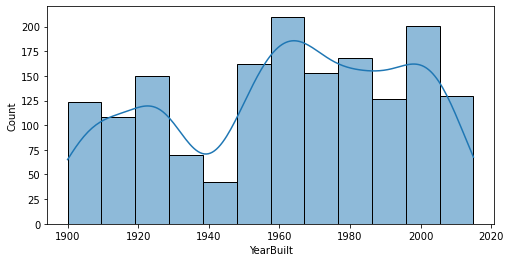

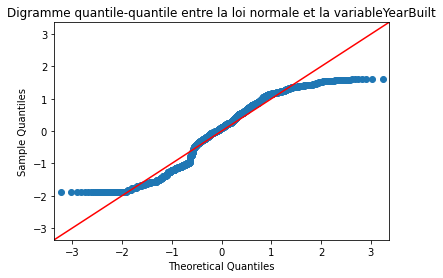

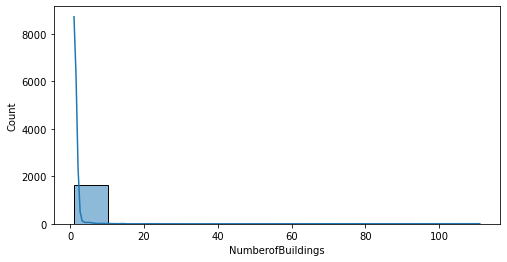

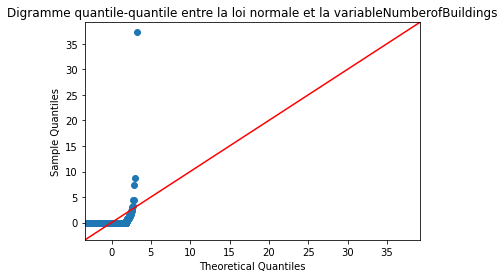

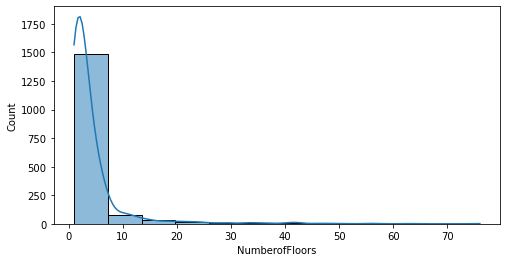

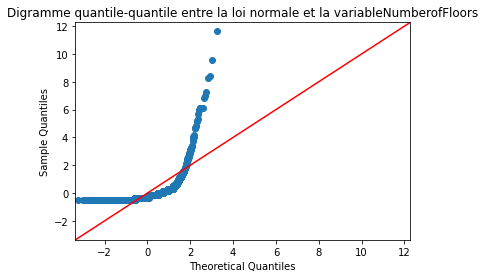

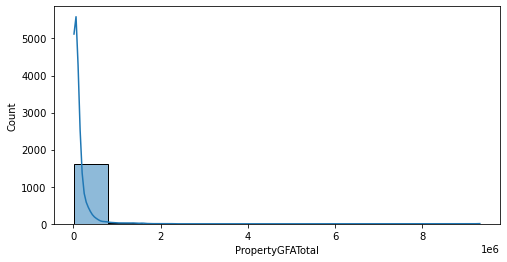

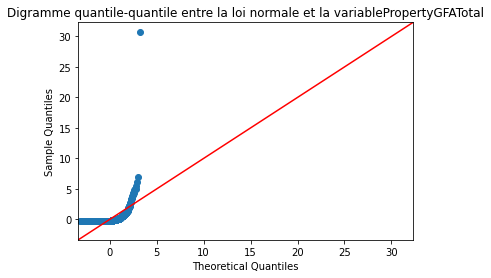

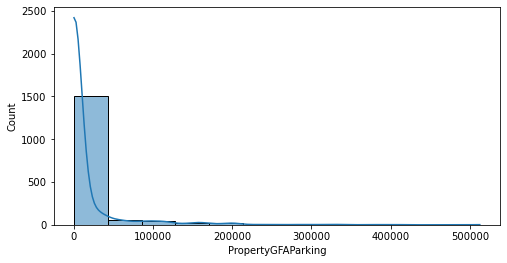

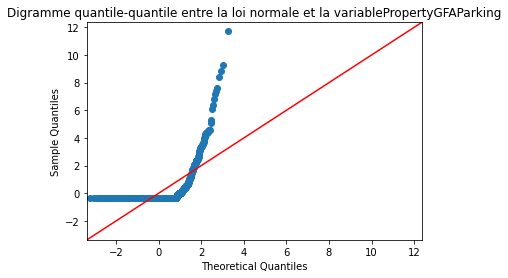

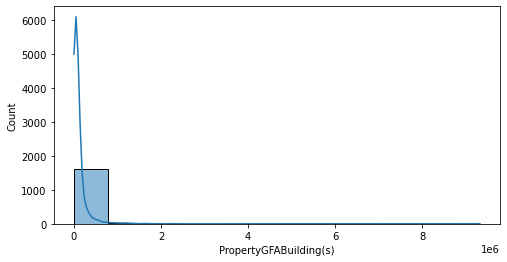

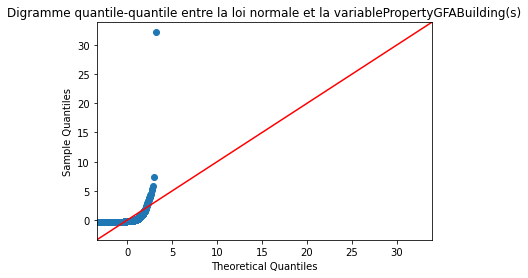

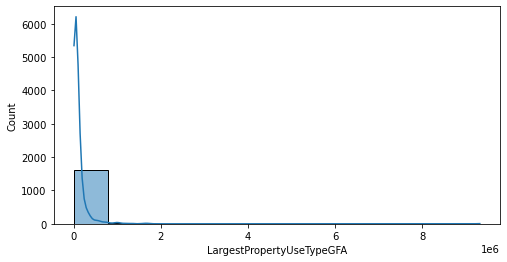

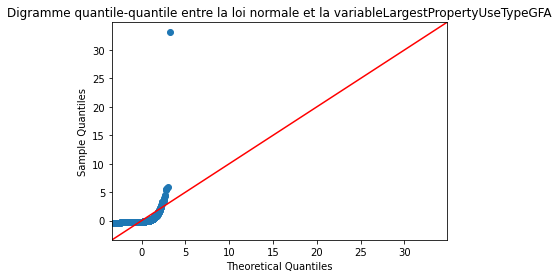

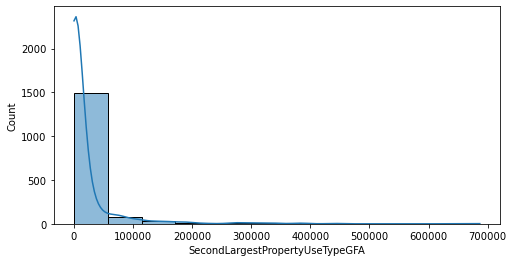

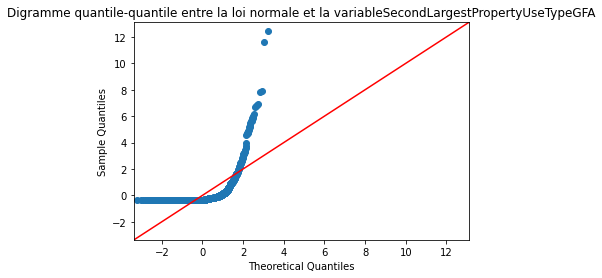

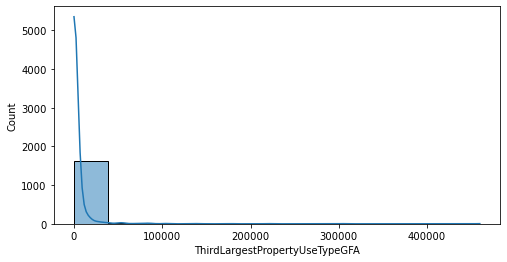

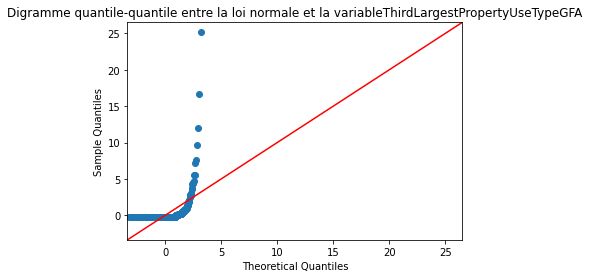

In [323]:
var_size = ['YearBuilt','NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 
            'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
           'ThirdLargestPropertyUseTypeGFA']

for var in var_size:
    # Histogramme de distribution
   

    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    ax = sns.histplot(data=data, x=data[var], bins="sturges", kde=True)
    plt.show()
  
    # diagramme quantile-quantile nutriscore et la loi normale

    sm.qqplot(data[var], fit=True, line="45")
    plt.title("Digramme quantile-quantile entre la loi normale et la variable" + var)
    plt.show()

Nous remarquons que les distributions de toutes les variables ne semblent pas suivre la loi normale, la plupart ont une allure très semblable (asymétrie à droite).

*Variables liées à la position géographique*

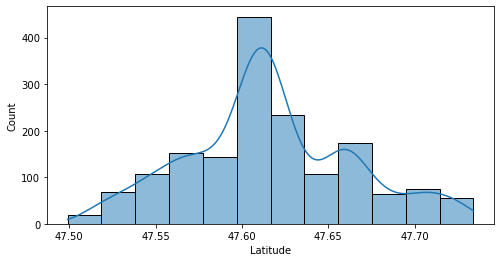

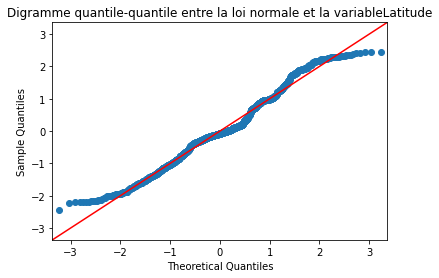

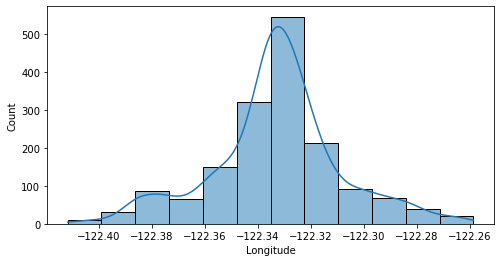

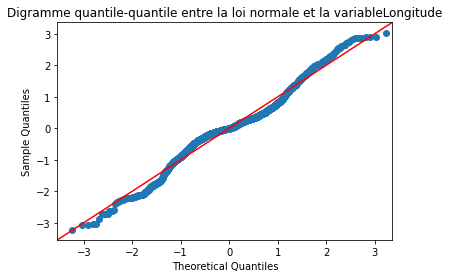

In [324]:
var_geo = ['Latitude', 'Longitude']

for var in var_geo:
    
    # Histogramme de distribution
   
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    ax = sns.histplot(data=data, x=data[var], bins="sturges", kde=True)
    plt.show()
  
    # diagramme quantile-quantile nutriscore et la loi normale

    sm.qqplot(data[var], fit=True, line="45")
    plt.title("Digramme quantile-quantile entre la loi normale et la variable" + var)
    plt.show()

*Variables energy*

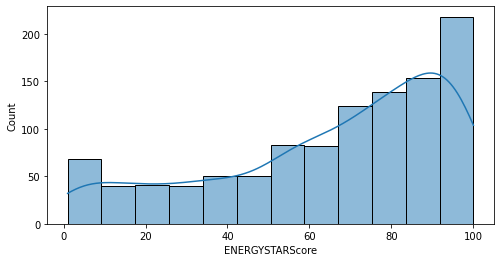

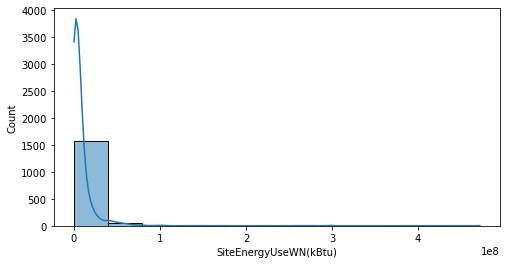

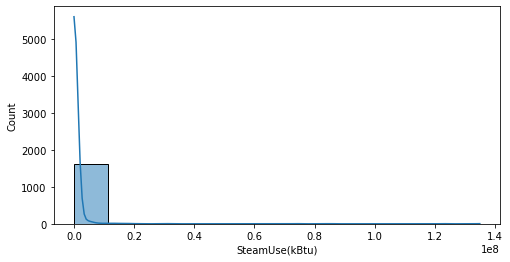

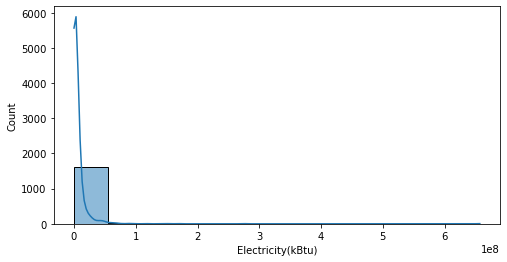

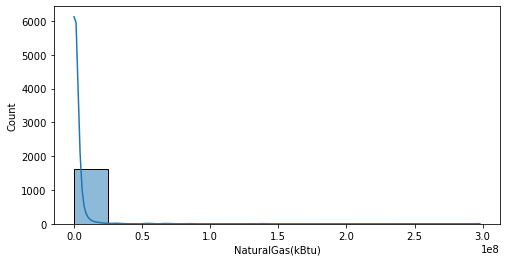

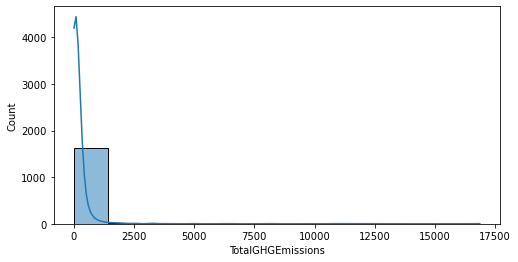

In [325]:
var_energy = ['ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 
           'NaturalGas(kBtu)', 'TotalGHGEmissions']

for var in var_energy:
    # Histogramme de distribution
   
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    ax = sns.histplot(data=data, x=data[var], bins="sturges", kde=True)
    plt.show()

In [326]:
from scipy import stats

# test de normalité de distribution des variables numériques

for column in var_num:
    print('________\n{}'.format(column))
    D, p = stats.kstest(data[column].dropna(), 
                     'norm', 
                     args=(data[column].mean(), data[column].std()))
    alpha = 5e-2
    print("p = {}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("HO est rejetée : {} n'est pas distribuée normalement".format(column))
    else:
        print("HO n'est pas rejetée")

________
YearBuilt
p = 1.6969278383489536e-12
HO est rejetée : YearBuilt n'est pas distribuée normalement
________
NumberofBuildings
p = 0.0
HO est rejetée : NumberofBuildings n'est pas distribuée normalement
________
NumberofFloors
p = 1.274997926666142e-138
HO est rejetée : NumberofFloors n'est pas distribuée normalement
________
PropertyGFATotal
p = 9.07979304402584e-201
HO est rejetée : PropertyGFATotal n'est pas distribuée normalement
________
PropertyGFAParking
p = 1.3231699926518556e-261
HO est rejetée : PropertyGFAParking n'est pas distribuée normalement
________
PropertyGFABuilding(s)
p = 2.762648392821206e-206
HO est rejetée : PropertyGFABuilding(s) n'est pas distribuée normalement
________
Latitude
p = 7.113241636368574e-13
HO est rejetée : Latitude n'est pas distribuée normalement
________
Longitude
p = 2.7465194438421856e-12
HO est rejetée : Longitude n'est pas distribuée normalement
________
LargestPropertyUseTypeGFA
p = 1.6363089071615038e-200
HO est rejetée : LargestPro

**Variables catégorielles**

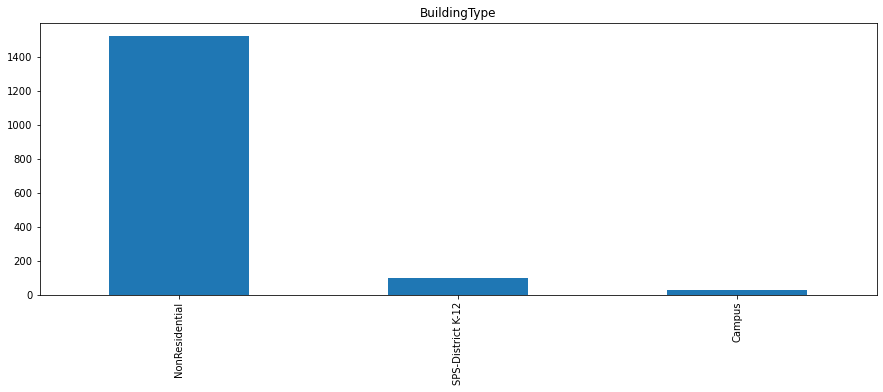

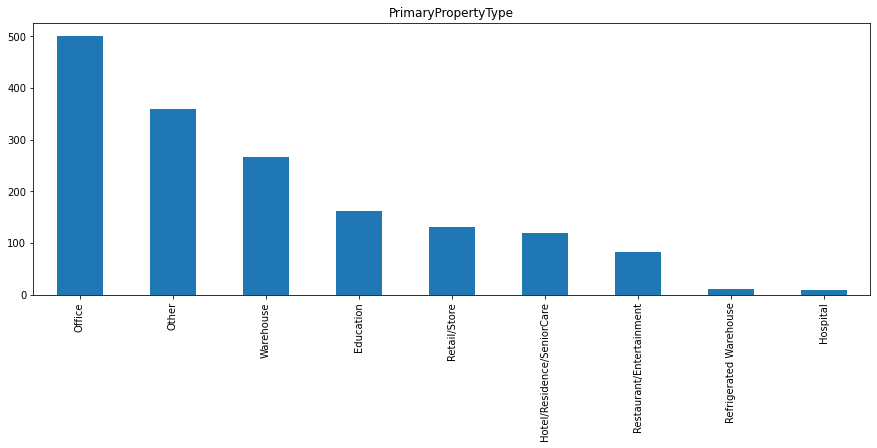

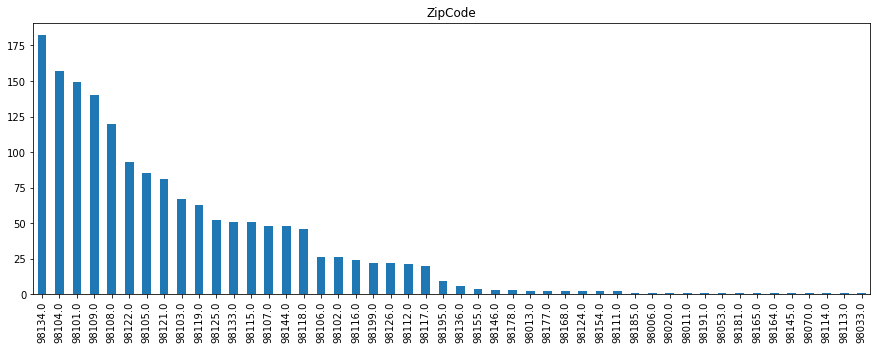

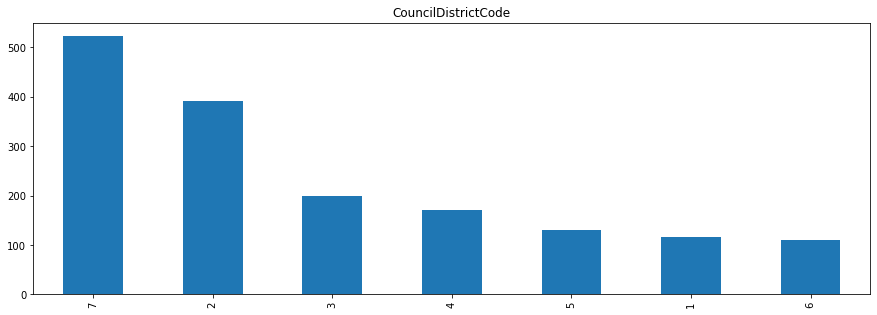

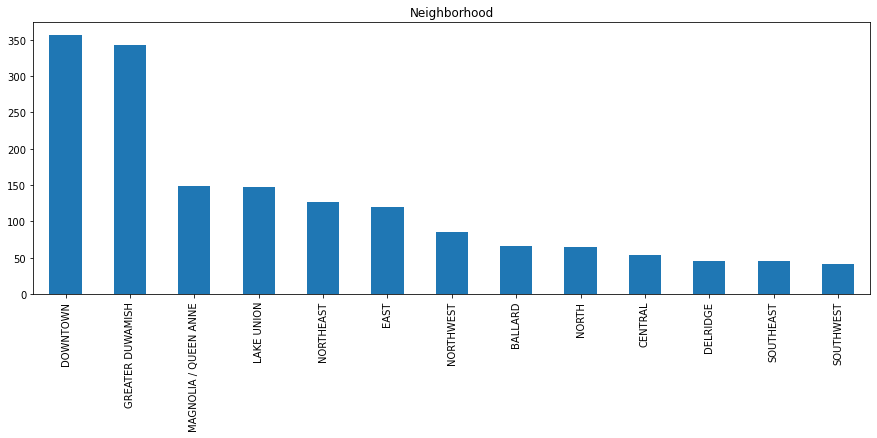

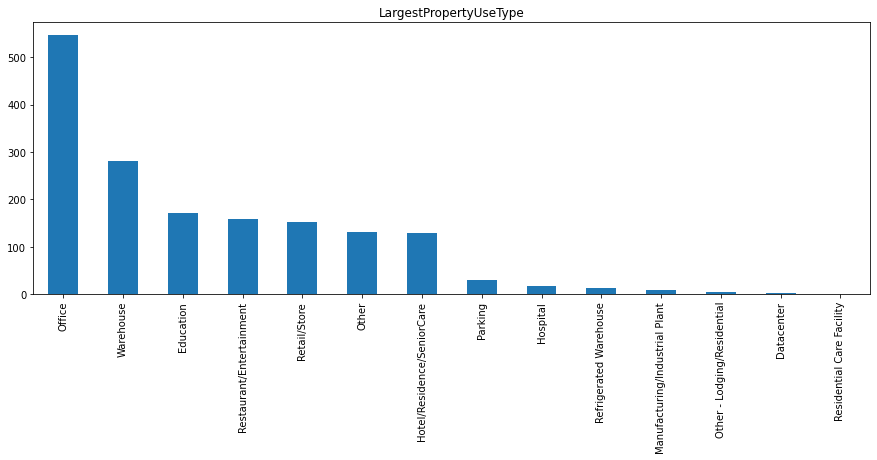

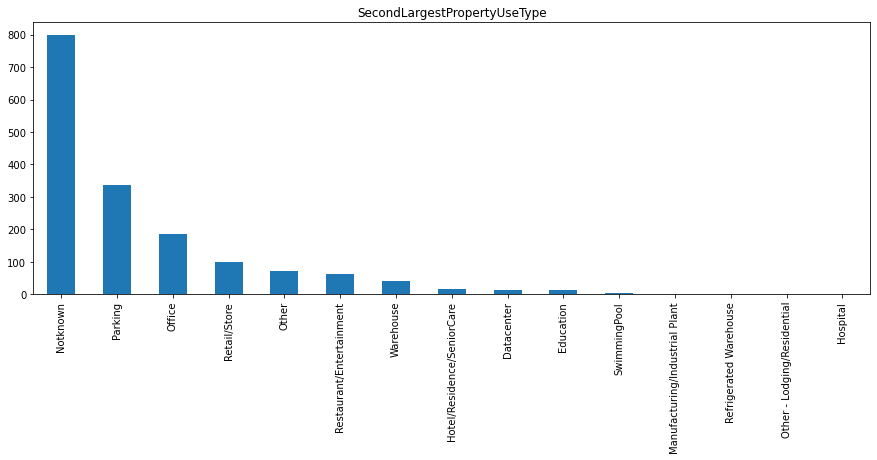

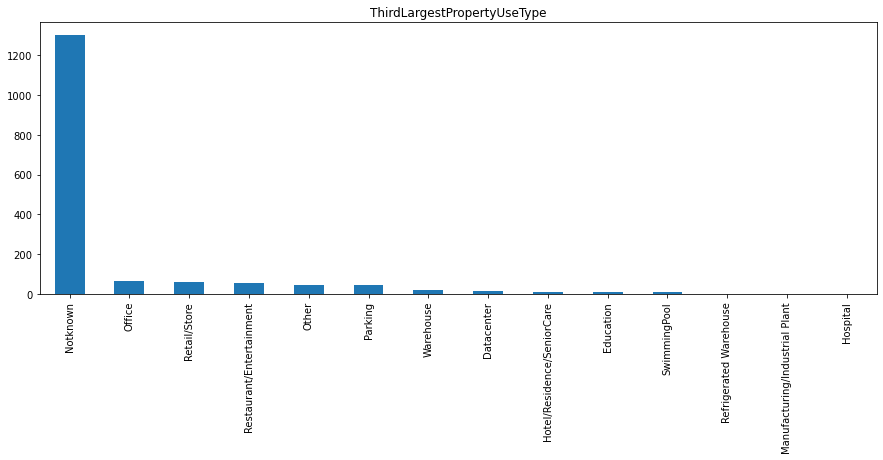

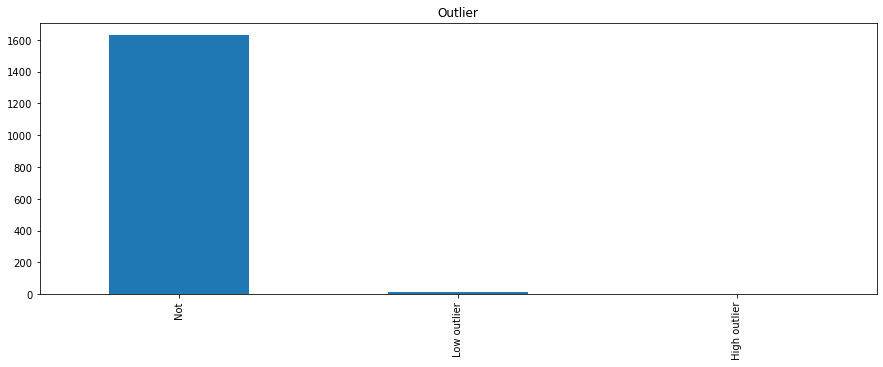

In [327]:
# Variables catégorielles

for var in var_cat:
    plt.figure(figsize=(15, 5))
    data.loc[:, var].value_counts().plot.bar()
    plt.title(var)
    fig.tight_layout(pad=0.8)

**Corrélations**

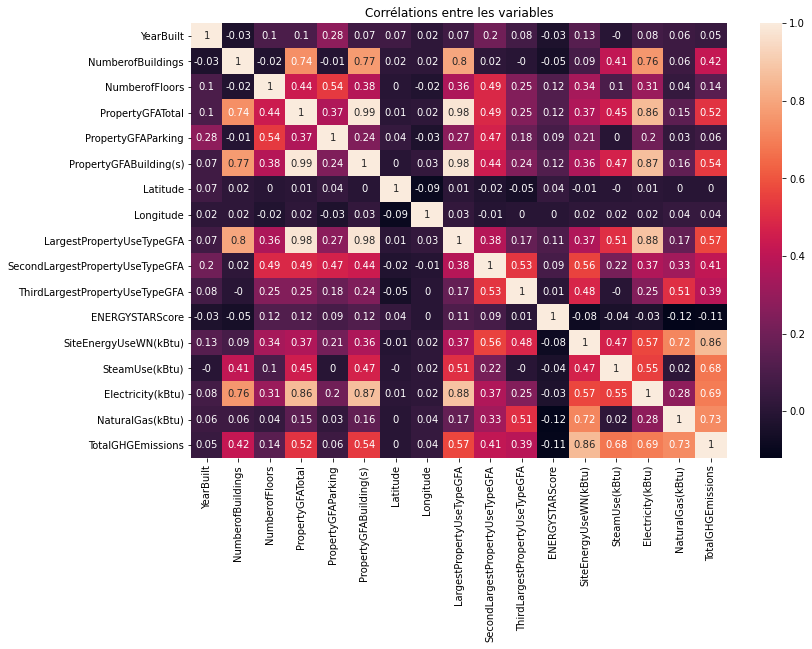

In [328]:
# corrélation des variables (heatmap)

corr = data[var_num].corr(method='pearson')
corr = corr.round(decimals=2)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True)
plt.title("Corrélations entre les variables", color= 'black')
plt.show()

Des fortes corrélations positives idéntifiées entre :

- PropertyGFATotal et PropertyGFABuilding(s) (0.99) 
                   et LargestPropertyUseTypeGFA (0.98)


- Deux variables cibles : SiteEnergyUse(kBtu) et TotalGHGEmissions (0.86)

    
- Electricity(kBtu) et LargestPropertyUseTypeGFA (0.88)
                    et PropertyGFABuilding(s) (0.87)
                    et PropertyGFATotal (0.86)

Certaines variables sont redondantes, nous allons les supprimer ou transformer dans des nouvelles variables.

Corrélations des variables cibles avec des variables explicatives :
    SiteEnergyUse(kBtu) et NumberofFloors (0.34)
                           toutes les variables liées à la surface (entre 0.21 et 0.56)
                           Pas de corrélation linéaire avec les variables YearBuilt et NumberofBuildings.
         
    TotalGHGEmissions   et NumberofBuildings (0.42)
                           toutes les variables liées à la surface (entre 0.39 et 0.57)

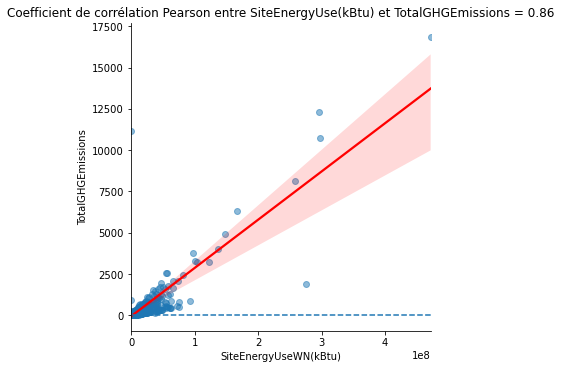

In [330]:
# correlation entre les variables cibles

sns.lmplot(data=data,x="SiteEnergyUseWN(kBtu)", y="TotalGHGEmissions", line_kws = {'color': 'red'},scatter_kws={'alpha':0.5})
# Ajout ligne horizontale TotalGHGEmissions minimum
plt.axhline(0, ls='--')
plt.title("Coefficient de corrélation Pearson entre SiteEnergyUse(kBtu) et TotalGHGEmissions = 0.86")
plt.show()

**Relations entre les variables catégorielles et les variables cibles (numériques)**

In [331]:
# varaibles catégorielles

var_cat

['BuildingType',
 'PrimaryPropertyType',
 'ZipCode',
 'CouncilDistrictCode',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Outlier']

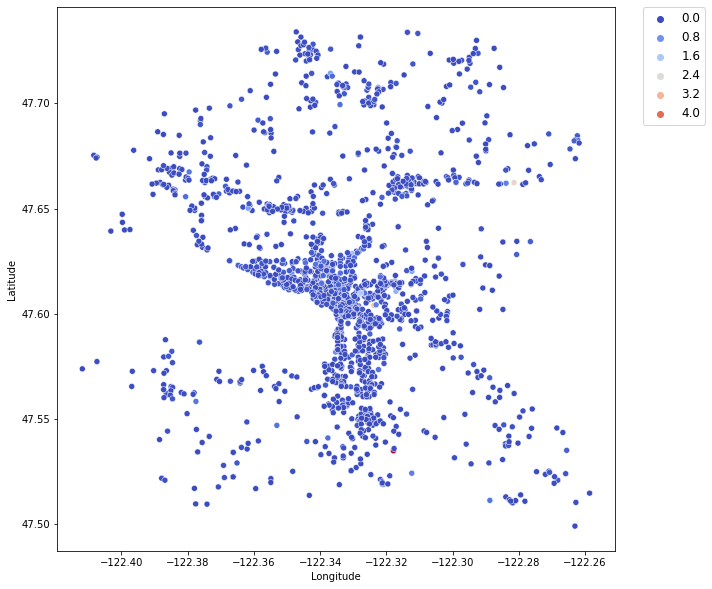

In [332]:
# Coordonnées géographiques des bâtiments et consommation

plt.figure(figsize=(10, 10))
sns.color_palette('coolwarm', as_cmap=True)
sns.scatterplot(x='Longitude', y='Latitude', data=data,
                hue=data['SiteEnergyUseWN(kBtu)'], palette='coolwarm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

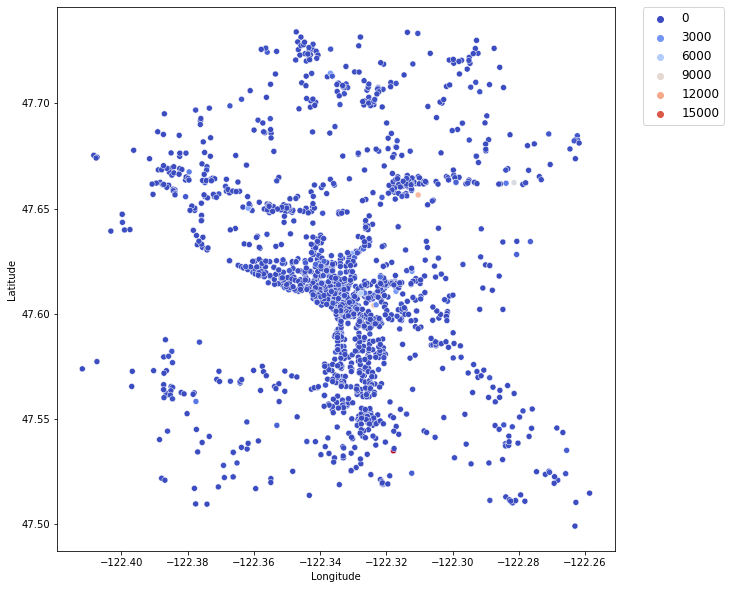

In [333]:
# Coordonnées géographiques des bâtiments et émissions

plt.figure(figsize=(10, 10))
sns.color_palette('coolwarm', as_cmap=True)
sns.scatterplot(x='Longitude', y='Latitude', data=data,
                hue=data['TotalGHGEmissions'], palette='coolwarm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.show()

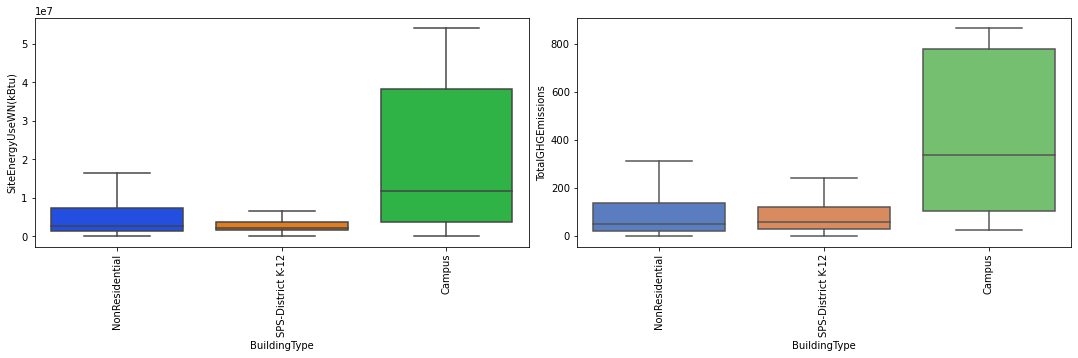

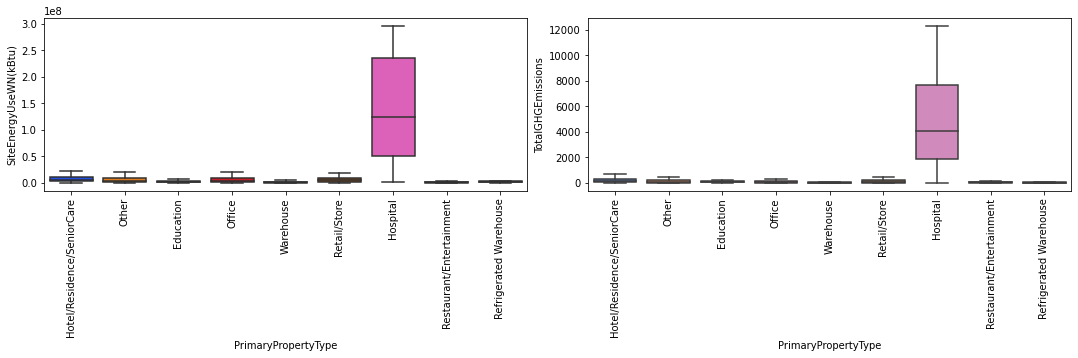

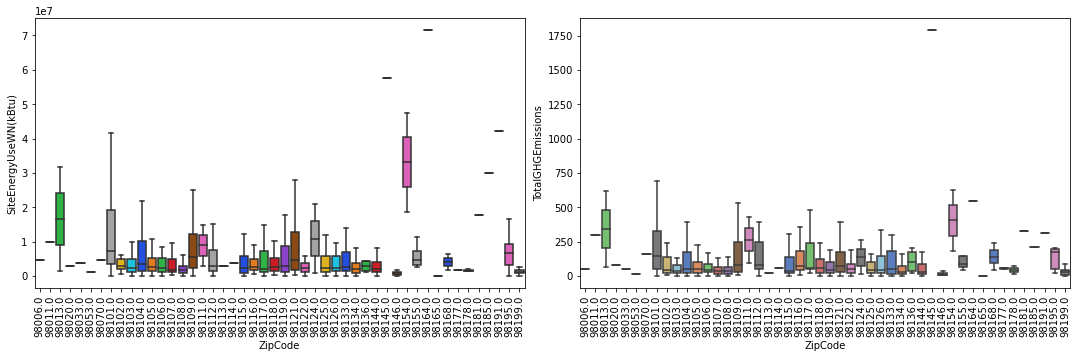

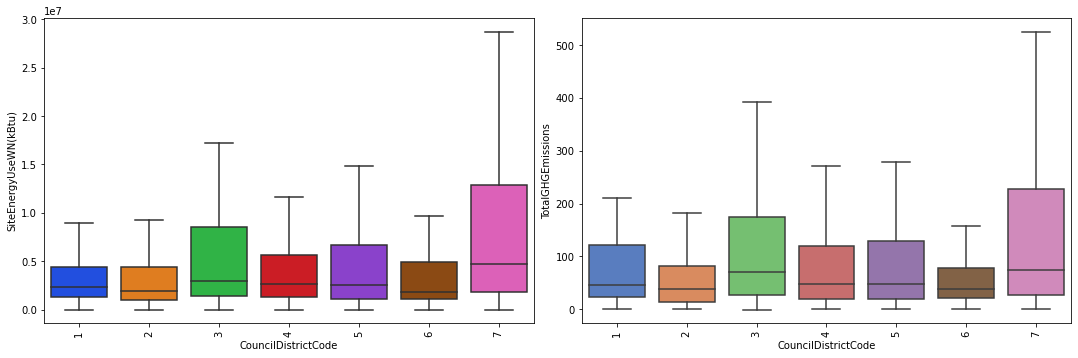

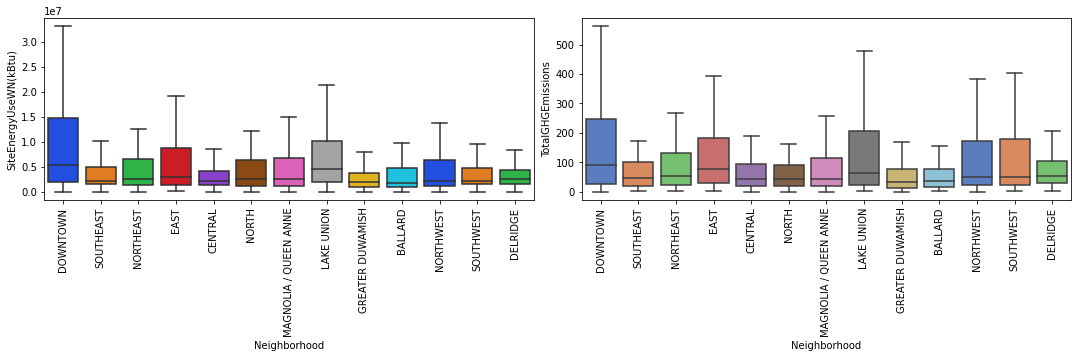

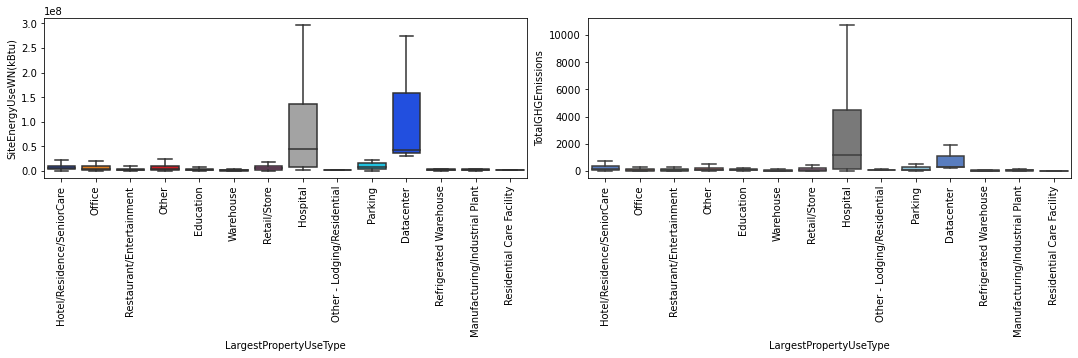

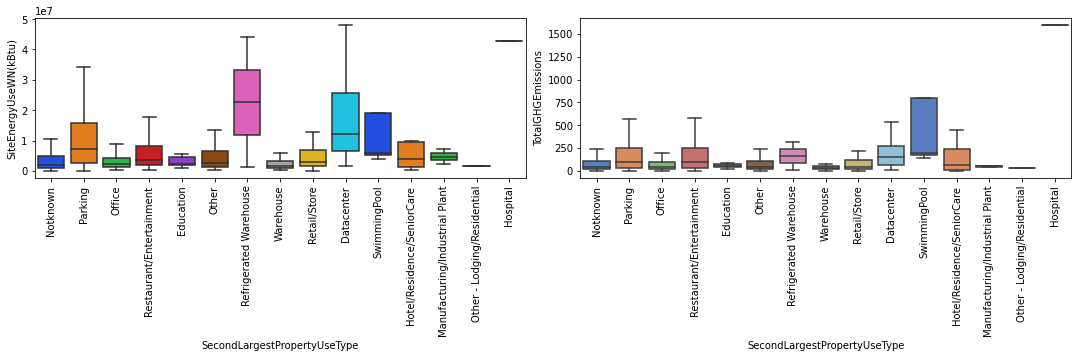

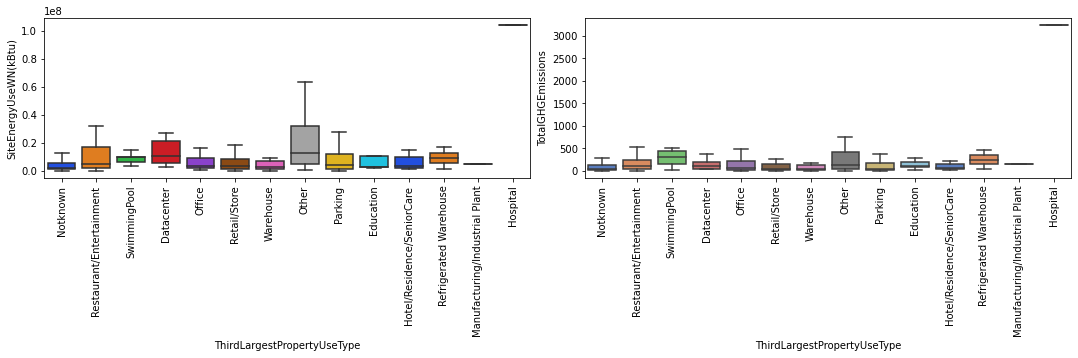

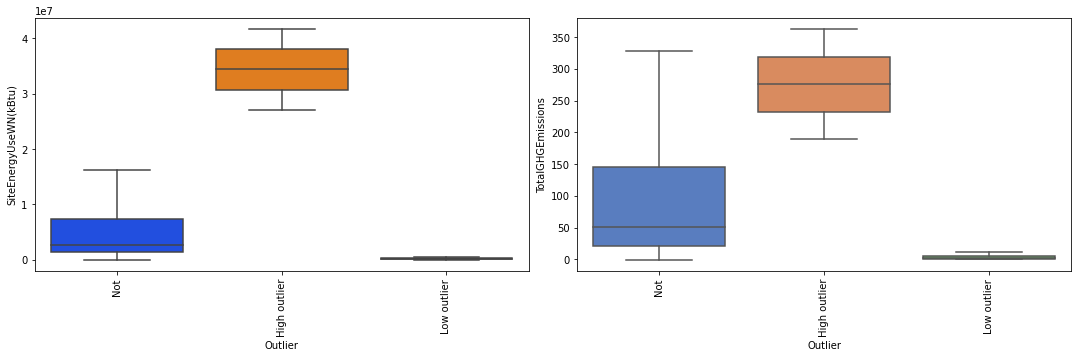

In [334]:
# Relations entre les varaibles catégorielles et cible (boxplot)

for col in data.loc[:, var_cat]:
    fig = plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    ax = sns.boxplot(y='SiteEnergyUseWN(kBtu)',
                         x=col,
                         palette='bright',
                         data=data,
                         showfliers=False)
    plt.xticks(rotation=90)

    plt.subplot(1, 2, 2)
    ax = sns.boxplot(y='TotalGHGEmissions',
                         x=col,
                         palette='muted',
                         data=data,
                         showfliers=False)
    plt.xticks(rotation=90)
    fig.tight_layout(pad=0.8)
 
plt.show()

In [335]:
# ANOVA variables catégorielles / variable cible SiteEnergyUseWN(kBtu)

import statsmodels.api as sm
from statsmodels.formula.api import ols
  
df_anova = df.rename(columns={"SiteEnergyUseWN(kBtu)":"SiteEnergyUse"})

for col in var_cat:
    model = ols(f'SiteEnergyUse~C({col})', data=df_anova).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(f' {col}')
    display(aov_table)
    print('\n')

 BuildingType


sum_sq      df          F        PR(>F)
C(BuildingType)  7.200631e+16     7.0  44.118999  5.061984e-60
Residual         7.838710e+17  3362.0        NaN           NaN



 PrimaryPropertyType


sum_sq      df          F         PR(>F)
C(PrimaryPropertyType)  2.622325e+17    23.0  64.262538  3.842480e-245
Residual                5.936448e+17  3346.0        NaN            NaN



 ZipCode


sum_sq      df         F        PR(>F)
C(ZipCode)  3.540096e+16    54.0  2.636755  1.243419e-09
Residual    8.202265e+17  3299.0       NaN           NaN



 CouncilDistrictCode


sum_sq      df         F    PR(>F)
C(CouncilDistrictCode)  8.600859e+15     6.0  5.689739  0.000007
Residual                8.472765e+17  3363.0       NaN       NaN



 Neighborhood


sum_sq      df         F        PR(>F)
C(Neighborhood)  1.832203e+16    18.0  4.072508  1.577693e-08
Residual         8.375553e+17  3351.0       NaN           NaN



 LargestPropertyUseType


sum_sq      df          F         PR(>F)
C(LargestPropertyUseType)  2.762495e+17    55.0  28.601079  5.369434e-235
Residual                   5.793470e+17  3299.0        NaN            NaN



 SecondLargestPropertyUseType


sum_sq      df         F        PR(>F)
C(SecondLargestPropertyUseType)  5.204403e+16    49.0  2.751848  1.846240e-09
Residual                         6.283545e+17  1628.0       NaN           NaN



 ThirdLargestPropertyUseType


sum_sq     df         F    PR(>F)
C(ThirdLargestPropertyUseType)  3.283493e+16   43.0  1.472092  0.029619
Residual                        2.863332e+17  552.0       NaN       NaN



 Outlier


sum_sq    df          F    PR(>F)
C(Outlier)  1.027451e+15   1.0  21.119151  0.000073
Residual    1.459507e+15  30.0        NaN       NaN

In [336]:
# ANOVA variables catégorielles / varible cible TotalGHGEmissions

import statsmodels.api as sm
from statsmodels.formula.api import ols
  
for col in var_cat:
    model = ols(f'TotalGHGEmissions~C({col})', data=df_anova).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(f' {col}')
    display(aov_table)
    print('\n')

 BuildingType


sum_sq      df          F        PR(>F)
C(BuildingType)  8.805998e+07     7.0  47.520268  1.149147e-64
Residual         8.892250e+08  3359.0        NaN           NaN



 PrimaryPropertyType


sum_sq      df          F         PR(>F)
C(PrimaryPropertyType)  2.949758e+08    23.0  62.836754  3.204277e-240
Residual                6.823092e+08  3343.0        NaN            NaN



 ZipCode


sum_sq      df         F    PR(>F)
C(ZipCode)  1.849984e+07    54.0  1.177915  0.176577
Residual    9.586219e+08  3296.0       NaN       NaN



 CouncilDistrictCode


sum_sq      df         F    PR(>F)
C(CouncilDistrictCode)  4.405871e+06     6.0  2.536068  0.018821
Residual                9.728791e+08  3360.0       NaN       NaN



 Neighborhood


sum_sq      df         F    PR(>F)
C(Neighborhood)  7.604168e+06    18.0  1.458599  0.094947
Residual         9.696808e+08  3348.0       NaN       NaN



 LargestPropertyUseType


sum_sq      df          F         PR(>F)
C(LargestPropertyUseType)  2.913983e+08    55.0  25.497707  2.271407e-210
Residual                   6.857048e+08  3300.0        NaN            NaN



 SecondLargestPropertyUseType


sum_sq      df         F        PR(>F)
C(SecondLargestPropertyUseType)  4.624962e+07    49.0  2.413483  2.485929e-07
Residual                         6.370727e+08  1629.0       NaN           NaN



 ThirdLargestPropertyUseType


sum_sq     df         F    PR(>F)
C(ThirdLargestPropertyUseType)  2.652050e+07   43.0  1.144217  0.249461
Residual                        2.975390e+08  552.0       NaN       NaN



 Outlier


sum_sq    df          F    PR(>F)
C(Outlier)  454720.237514   1.0  35.223798  0.000002
Residual    387283.817574  30.0        NaN       NaN

## 5. Feature engineering

In [337]:
df_model = data.copy() 

In [338]:
df_model.head()

OSEBuildingID    BuildingType         PrimaryPropertyType  ZipCode  \
0              1  NonResidential  Hotel/Residence/SeniorCare  98101.0   
1              2  NonResidential  Hotel/Residence/SeniorCare  98101.0   
2              3  NonResidential  Hotel/Residence/SeniorCare  98101.0   
3              5  NonResidential  Hotel/Residence/SeniorCare  98101.0   
4              8  NonResidential  Hotel/Residence/SeniorCare  98121.0   

  CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
0                   7     DOWNTOWN  47.61220 -122.33799       1927   
1                   7     DOWNTOWN  47.61317 -122.33393       1996   
2                   7     DOWNTOWN  47.61393 -122.33810       1969   
3                   7     DOWNTOWN  47.61412 -122.33664       1926   
4                   7     DOWNTOWN  47.61375 -122.34047       1980   

   NumberofBuildings  ...  SecondLargestPropertyUseTypeGFA  \
0                  1  ...                              0.0   
1                  1  ...                          15064.0   
2                  1  ...                              0.0   
3                  1  ...                              0.0   
4                  1  ...                          68009.0   

   ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                     Notknown                             0.0   
1     Restaurant/Entertainment                          4622.0   
2                     Notknown                             0.0   
3                     Notknown                             0.0   
4                 SwimmingPool                             0.0   

   ENERGYSTARScore SiteEnergyUseWN(kBtu)  SteamUse(kBtu) Electricity(kBtu)  \
0             60.0             7456910.0      2003882.00         3946027.0   
1             61.0             8664479.0            0.00         3242851.0   
2             43.0            73937112.0     21566554.00        49526664.0   
3             56.0             6946800.5      2214446.25         2768924.0   
4             75.0            14656503.0            0.00         5368607.0   

   NaturalGas(kBtu) Outlier  TotalGHGEmissions  
0         1276453.0     Not             249.98  
1         5145082.0     Not             295.86  
2         1493800.0     Not            2089.28  
3         1811213.0     Not             286.43  
4         8803998.0     Not             505.01  

[5 rows x 27 columns]

**Transformer la date de construction du bâtiment en âge du bâtiment**

In [339]:
# Ajout d'une nouvelle variable 'Age'

df_model['BuildingAge'] = 2023 - df_model['YearBuilt']

In [340]:
# Supprimer la colonne non utile

df_model.drop('YearBuilt', axis=1, inplace=True)

**Passage en logarithme les varaibles cibles**

Les variables cible 'SiteEnergyUseWN(kBtu)' et 'TotalGHGEmissions' ne suivent pas la loi normale, nous allons appliquer la transformation logarithmique.

<Figure size 720x432 with 0 Axes>

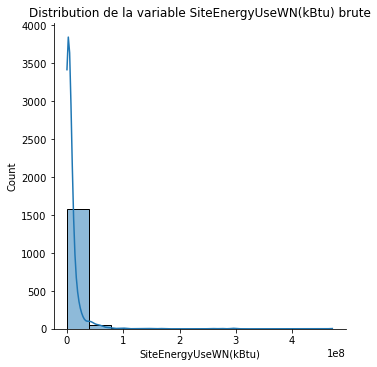

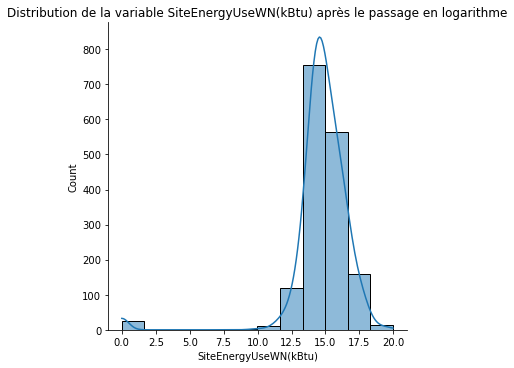

In [341]:
# Visualisation de la transformation logarithmique de la variable 'SiteEnergyUseWN(kBtu)'

fig = plt.figure(figsize=(10,6))
ax=sns.displot(x=df_model['SiteEnergyUseWN(kBtu)'],bins="sturges", kde=True)
plt.title("Distribution de la variable SiteEnergyUseWN(kBtu) brute")

ax=sns.displot(x=np.log(1 + df_model['SiteEnergyUseWN(kBtu)']),bins="sturges", kde=True)
plt.title("Distribution de la variable SiteEnergyUseWN(kBtu) après le passage en logarithme")
plt.show()

In [342]:
# Ajout d'une nouvelle variable 'SiteEnergyUseWN(kBtu)_log'

df_model['SiteEnergyUseWN(kBtu)_log'] = np.log(1+df_model['SiteEnergyUseWN(kBtu)'])

<Figure size 720x432 with 0 Axes>

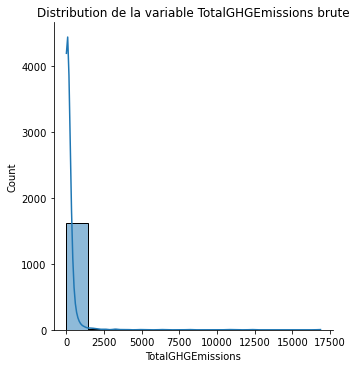

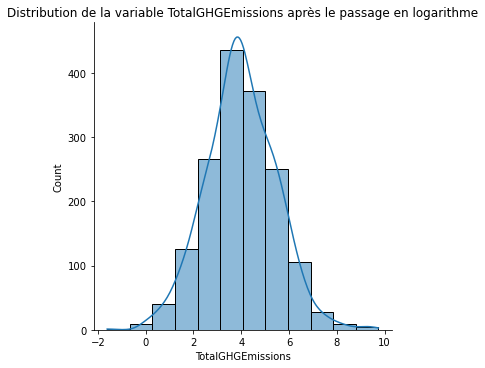

In [343]:
# Visualisation de la transformation logarithmique de la variable 'TotalGHGEmissions' 

fig = plt.figure(figsize=(10,6))
ax=sns.displot(x=df_model['TotalGHGEmissions'],bins="sturges", kde=True)
plt.title("Distribution de la variable TotalGHGEmissions brute")

ax=sns.displot(x=np.log(1 + df_model['TotalGHGEmissions']),bins="sturges", kde=True)
plt.title("Distribution de la variable TotalGHGEmissions après le passage en logarithme")
plt.show()

In [344]:
# Ajout d'une nouvelle variable 'TotalGHGEmissions_log'

df_model['TotalGHGEmissions_log'] = np.log(1 + df_model['TotalGHGEmissions'])

**Transformation des variables 'PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)**

Les 3 variables sont fortement corrélées, on conserve la variable 'PropertyGFABuilding(s)' et on constitue une nouvelle variable avec le pourcentage de la surface du parking sur la surface totale.

In [345]:
# Ajout d'une nouvelle variable 'TauxParkingGFA'

df_model['TauxParkingGFA'] = df_model['PropertyGFAParking'] / df_model['PropertyGFATotal']

In [346]:
# Supprimer les colonnes non utiles

df_model.drop('PropertyGFATotal', axis=1, inplace=True)
df_model.drop('PropertyGFAParking', axis=1, inplace=True)

**Transformation des variables 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'**

Nous allons créer des nouvelles variables avec le pourcentage de la surface sur la surface totale pour chaque type d'utilisation (1er, 2ème, 3ème).

In [347]:
# Ajout de 3 nouvelles variables 'TauxFirstUseGFA', 'TauxSecondtUseGFA'
# et 'TauxThirdtUseGFA'

df_model['TauxFirstUseGFA'] = df_model['LargestPropertyUseTypeGFA'] / \
    data['PropertyGFATotal']
df_model['TauxSecondtUseGFA'] = df_model['SecondLargestPropertyUseTypeGFA'] / \
    data['PropertyGFATotal']
df_model['TauxThirdtUseGFA'] = df_model['ThirdLargestPropertyUseTypeGFA'] / \
    data['PropertyGFATotal']

In [349]:
# Supprimer les colonnes non utiles

df_model.drop('LargestPropertyUseTypeGFA', axis=1, inplace=True)
df_model.drop('SecondLargestPropertyUseTypeGFA', axis=1, inplace=True)
df_model.drop('ThirdLargestPropertyUseTypeGFA', axis=1, inplace=True)

**Transformation des variables 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'**

Nous allons créer des nouvelles variables avec le pourcentage de consommation par type d'énergie.

In [350]:
df_model['TauxSteamUse(kBtu)'] = df_model['SteamUse(kBtu)'] / (df_model['SteamUse(kBtu)'] + df_model['Electricity(kBtu)']
                                                               + df_model['NaturalGas(kBtu)'])
df_model['TauxElectricity(kBtu)'] = df_model['Electricity(kBtu)'] / (df_model['SteamUse(kBtu)'] + df_model['Electricity(kBtu)']
                                                               + df_model['NaturalGas(kBtu)'])   
df_model['TauxNaturalGas(kBtu)'] = df_model['NaturalGas(kBtu)'] / (df_model['SteamUse(kBtu)'] + df_model['Electricity(kBtu)']
                                                               + df_model['NaturalGas(kBtu)'])

**Transformation logarithmique de la variable PropertyGFABuilding(s)**

<Figure size 720x432 with 0 Axes>

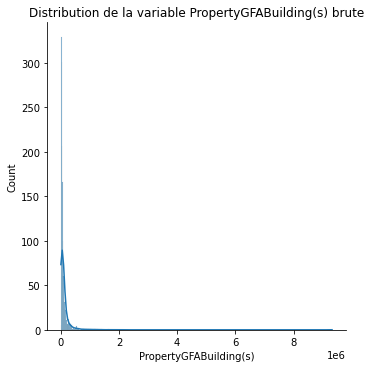

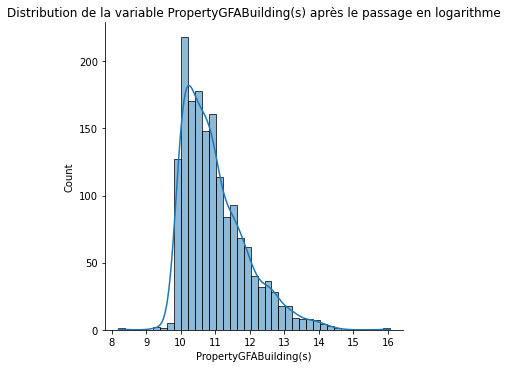

In [376]:
# Visualisation de la transformation logarithmique de la variable 'PropertyGFABuilding(s)' 

fig = plt.figure(figsize=(10,6))
ax=sns.displot(x=df_model['PropertyGFABuilding(s)'], kde=True)
plt.title("Distribution de la variable PropertyGFABuilding(s) brute")

ax=sns.displot(x=np.log(df_model['PropertyGFABuilding(s)']), kde=True)
plt.title("Distribution de la variable PropertyGFABuilding(s) après le passage en logarithme")
plt.show()

In [378]:
# Ajout d'une nouvelle variable 'PropertyGFABuilding(s)_log'

df_model['PropertyGFABuilding(s)_log'] = np.log(df_model['PropertyGFABuilding(s)'])

In [351]:
# Supprimer les colonnes non utiles

df_model.drop('SteamUse(kBtu)', axis=1, inplace=True)
df_model.drop('Electricity(kBtu)', axis=1, inplace=True)
df_model.drop('NaturalGas(kBtu)', axis=1, inplace=True)
df_model.drop('Latitude', axis=1, inplace=True)
df_model.drop('Longitude', axis=1, inplace=True)
df_model.drop('PropertyGFABuilding(s)', axis=1, inplace=True)

In [415]:
df_model.describe()

OSEBuildingID  NumberofBuildings  NumberofFloors  ENERGYSTARScore  \
count    1619.000000        1619.000000     1619.000000      1080.000000   
mean    16080.198271           1.137122        4.101297        65.363889   
std     13401.619860           1.158501        6.182704        28.568860   
min         1.000000           1.000000        1.000000         1.000000   
25%       585.500000           1.000000        1.000000        48.000000   
50%     21142.000000           1.000000        2.000000        73.000000   
75%     24580.000000           1.000000        4.000000        89.000000   
max     50101.000000          27.000000       76.000000       100.000000   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  BuildingAge  \
count           1.619000e+03        1619.000000  1619.000000   
mean            8.259051e+06         181.094558    61.256949   
std             2.231543e+07         711.856827    32.764632   
min             1.726000e+04          -0.800000     8.000000   
25%             1.357733e+06          20.295000    34.000000   
50%             2.762806e+06          50.070000    58.000000   
75%             7.367000e+06         142.375000    93.000000   
max             4.716139e+08       16870.980000   123.000000   

       SiteEnergyUseWN(kBtu)_log  TotalGHGEmissions_log  TauxParkingGFA  \
count                1619.000000            1619.000000     1619.000000   
mean                   14.968451               4.002278        0.062116   
std                     1.302806               1.453162        0.140814   
min                     9.756205              -1.609438        0.000000   
25%                    14.121328               3.058472        0.000000   
50%                    14.831758               3.933197        0.000000   
75%                    15.812520               4.965464        0.000000   
max                    19.971671               9.733410        0.895023   

       TauxFirstUseGFA  TauxSecondtUseGFA  TauxThirdtUseGFA  \
count      1619.000000        1619.000000       1619.000000   
mean          0.869588           0.123637          0.022066   
std           0.307785           0.171621          0.062467   
min           0.186469           0.000000          0.000000   
25%           0.690636           0.000000          0.000000   
50%           0.961306           0.000000          0.000000   
75%           1.000000           0.237895          0.000000   
max           6.426849           1.452054          0.929094   

       TauxSteamUse(kBtu)  TauxElectricity(kBtu)  TauxNaturalGas(kBtu)  \
count         1619.000000            1619.000000           1619.000000   
mean             0.021091               0.700229              0.278680   
std              0.091358               0.262543              0.264074   
min              0.000000               0.000000              0.000000   
25%              0.000000               0.489953              0.000000   
50%              0.000000               0.704985              0.241142   
75%              0.000000               1.000000              0.494296   
max              0.766988               1.000000              1.000000   

       PropertyGFABuilding(s)_log  
count                 1619.000000  
mean                    10.971725  
std                      0.898855  
min                      8.198639  
25%                     10.260917  
50%                     10.765702  
75%                     11.460832  
max                     14.603968

In [403]:
# vérification

df_model[df_model['SiteEnergyUseWN(kBtu)']==0]

OSEBuildingID       BuildingType       PrimaryPropertyType  ZipCode  \
28               34  SPS-District K-12                 Education  98112.0   
31               37  SPS-District K-12                 Education  98109.0   
62               87  SPS-District K-12                 Education  98146.0   
81              118  SPS-District K-12                 Education  98106.0   
85              122  SPS-District K-12                 Education  98144.0   
95              140  SPS-District K-12                 Education  98103.0   
133             217  SPS-District K-12                 Education  98117.0   
139             227  SPS-District K-12                 Education  98144.0   
152             242  SPS-District K-12                 Education  98115.0   
220             343     NonResidential                    Office  98104.0   
247             372     NonResidential                    Office  98101.0   
284             414     NonResidential                    Office  98101.0   
304             435     NonResidential                     Other  98101.0   
350             493     NonResidential                    Office  98119.0   
614             820  SPS-District K-12                 Education  98122.0   
630             850  SPS-District K-12                 Education  98122.0   
746           19776     NonResidential                     Other  98133.0   
882           20130     NonResidential  Restaurant/Entertainment  98115.0   
953           20324     NonResidential  Restaurant/Entertainment  98115.0   
1361          21616  SPS-District K-12                 Education  98125.0   
1894          23722  SPS-District K-12                 Education  98117.0   
3166          49703  SPS-District K-12                 Education  98199.0   
3274          49967             Campus                 Education  98105.0   
3275          49968     NonResidential                 Education  98195.0   
3277          49972     NonResidential                 Education  98195.0   

     CouncilDistrictCode           Neighborhood  NumberofBuildings  \
28                     3                CENTRAL                  1   
31                     7  MAGNOLIA / QUEEN ANNE                  1   
62                     1              SOUTHWEST                  1   
81                     1               DELRIDGE                  1   
85                     2              SOUTHEAST                  1   
95                     6             LAKE UNION                  1   
133                    6                BALLARD                  1   
139                    3                CENTRAL                  1   
152                    5                  NORTH                  1   
220                    7               DOWNTOWN                  1   
247                    7               DOWNTOWN                  1   
284                    7               DOWNTOWN                  1   
304                    7               DOWNTOWN                  1   
350                    7  MAGNOLIA / QUEEN ANNE                  1   
614                    3                CENTRAL                  1   
630                    3                CENTRAL                  1   
746                    5              NORTHWEST                  1   
882                    6              NORTHWEST                  1   
953                    4              NORTHEAST                  1   
1361                   5                  NORTH                  1   
1894                   6                BALLARD                  1   
3166                   7  MAGNOLIA / QUEEN ANNE                  1   
3274                   4              NORTHEAST                111   
3275                   4              NORTHEAST                  1   
3277                   4              NORTHEAST                  1   

      NumberofFloors    LargestPropertyUseType SecondLargestPropertyUseType  \
28                 1                 Education                     Notknown   
31                 2    

In [404]:
# index des lignes avec la consommation = 0

indexNames = df_model[df_model['SiteEnergyUseWN(kBtu)']==0].index

# Supprimer ces lignes
df_model.drop(indexNames , inplace=True)

In [406]:
# vérification

df_model[df_model['TauxSteamUse(kBtu)'].isna()]

OSEBuildingID    BuildingType PrimaryPropertyType  ZipCode  \
513            700  NonResidential        Retail/Store  98119.0   

    CouncilDistrictCode           Neighborhood  NumberofBuildings  \
513                   7  MAGNOLIA / QUEEN ANNE                  1   

     NumberofFloors LargestPropertyUseType SecondLargestPropertyUseType  ...  \
513               1           Retail/Store                 Retail/Store  ...   

    SiteEnergyUseWN(kBtu)_log  TotalGHGEmissions_log  TauxParkingGFA  \
513                 16.368376                    0.0             0.0   

    TauxFirstUseGFA  TauxSecondtUseGFA  TauxThirdtUseGFA  TauxSteamUse(kBtu)  \
513        0.690849           0.262348          0.096194                 NaN   

     TauxElectricity(kBtu)  TauxNaturalGas(kBtu)  PropertyGFABuilding(s)_log  
513                    NaN                   NaN                    10.95389  

[1 rows x 26 columns]

In [407]:
# index des lignes avec les taux de sources d'énergie Nan

indexNames = df_model[df_model['TauxSteamUse(kBtu)'].isna()].index

# Supprimer ces lignes

df_model.drop(indexNames , inplace=True)

<AxesSubplot:>

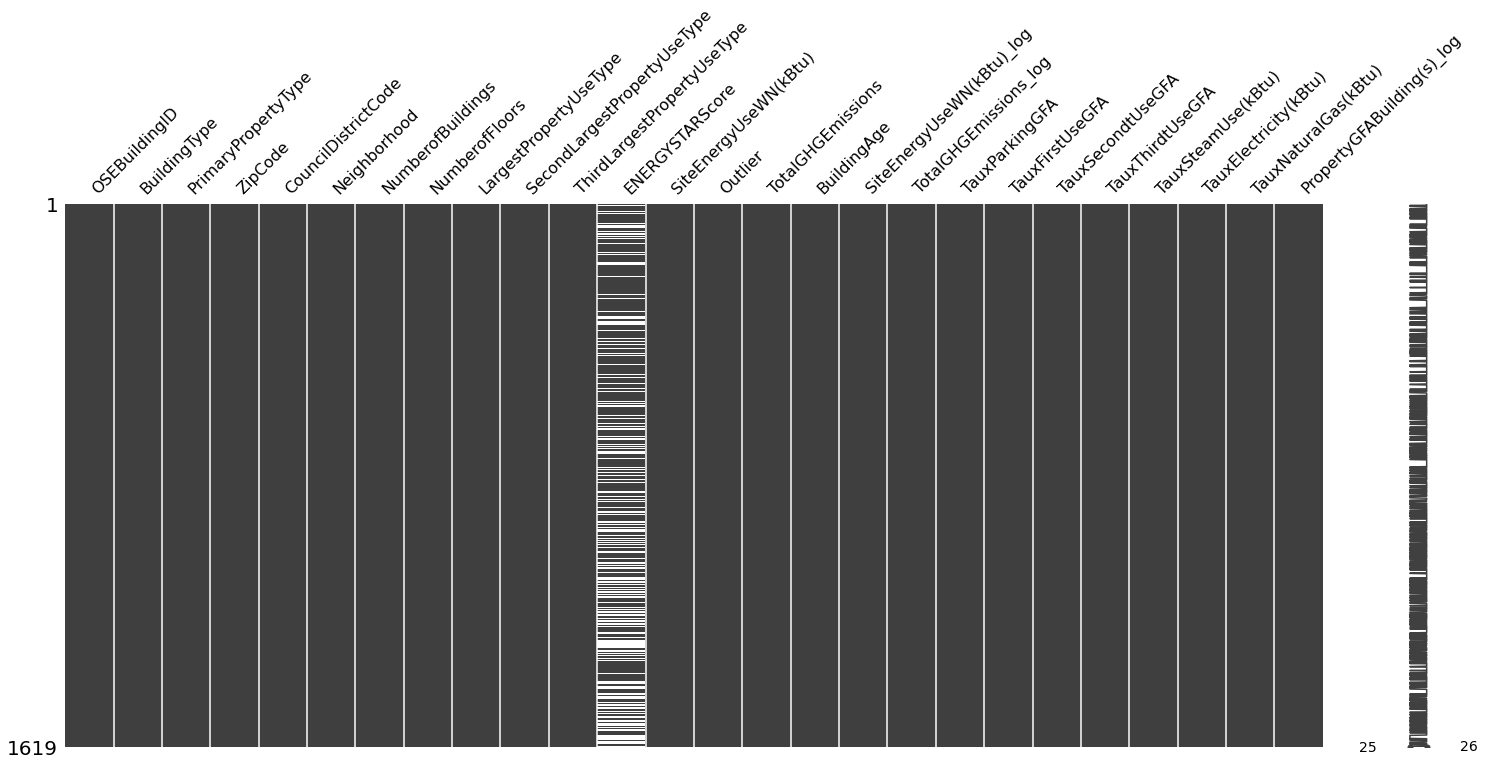

In [410]:
# taux de remplissage du dataframe final

msno.matrix(df_model)

## 6. Exportation des données pour la modélisation

In [411]:
# Exportation de jeu de données après feature engineering

df_model.to_csv("df_batiment_model.csv",header=True,index=False)

In [412]:
# Exportation de jeu de données avant feature engineering

data.to_csv("df_batiment_clean.csv",header=True,index=False)